<a href="https://colab.research.google.com/github/vedantdalvi7/Robustness-Evaluation-of-neural-network-based-image-processing-models/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libratries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow  import *
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import pathlib

# Load datasets

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

global classes_name
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
def load_data(path):
  x = np.load(pathlib.Path(path))
  print(x.shape)
  return x

x1 = load_data('/content/drive/MyDrive/Colab Notebooks/Research Project/brightness.npy')
x2 = load_data('/content/drive/MyDrive/Colab Notebooks/Research Project/gaussian_noise.npy')
x3 = load_data('/content/drive/MyDrive/Colab Notebooks/Research Project/gaussian_blur.npy')
x4 = load_data('/content/drive/MyDrive/Colab Notebooks/Research Project/zoom_blur.npy')
x5 = load_data('/content/drive/MyDrive/Colab Notebooks/Research Project/contrast.npy')



(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 32, 32, 3)
(50000, 32, 32, 3)


# Data Pre-processing

In [5]:
#Function to select specific severity level of corruptions

def select_severity(s, x):
  if s == 1:
    x = x[0:10000,:,:,:]
    print(x.shape)
    return x
  elif s == 2:
    x = x[10000:20000,:,:,:]
    print(x.shape)
    return x
  elif s == 3:
    x = x[20000:30000,:,:,:]
    print(x.shape)
    return x
  elif s == 4:
    x = x[30000:40000,:,:,:]
    print(x.shape)
    return x
  elif s == 5:
    x = x[40000:50000,:,:,:]
    print(x.shape)
    return x


x_bright = select_severity(5, x1)
x_gnoise = select_severity(5, x2)
x_gblur = select_severity(5, x3)
x_zoom_blur = select_severity(5, x4)
x_contrast = select_severity(5,x5)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


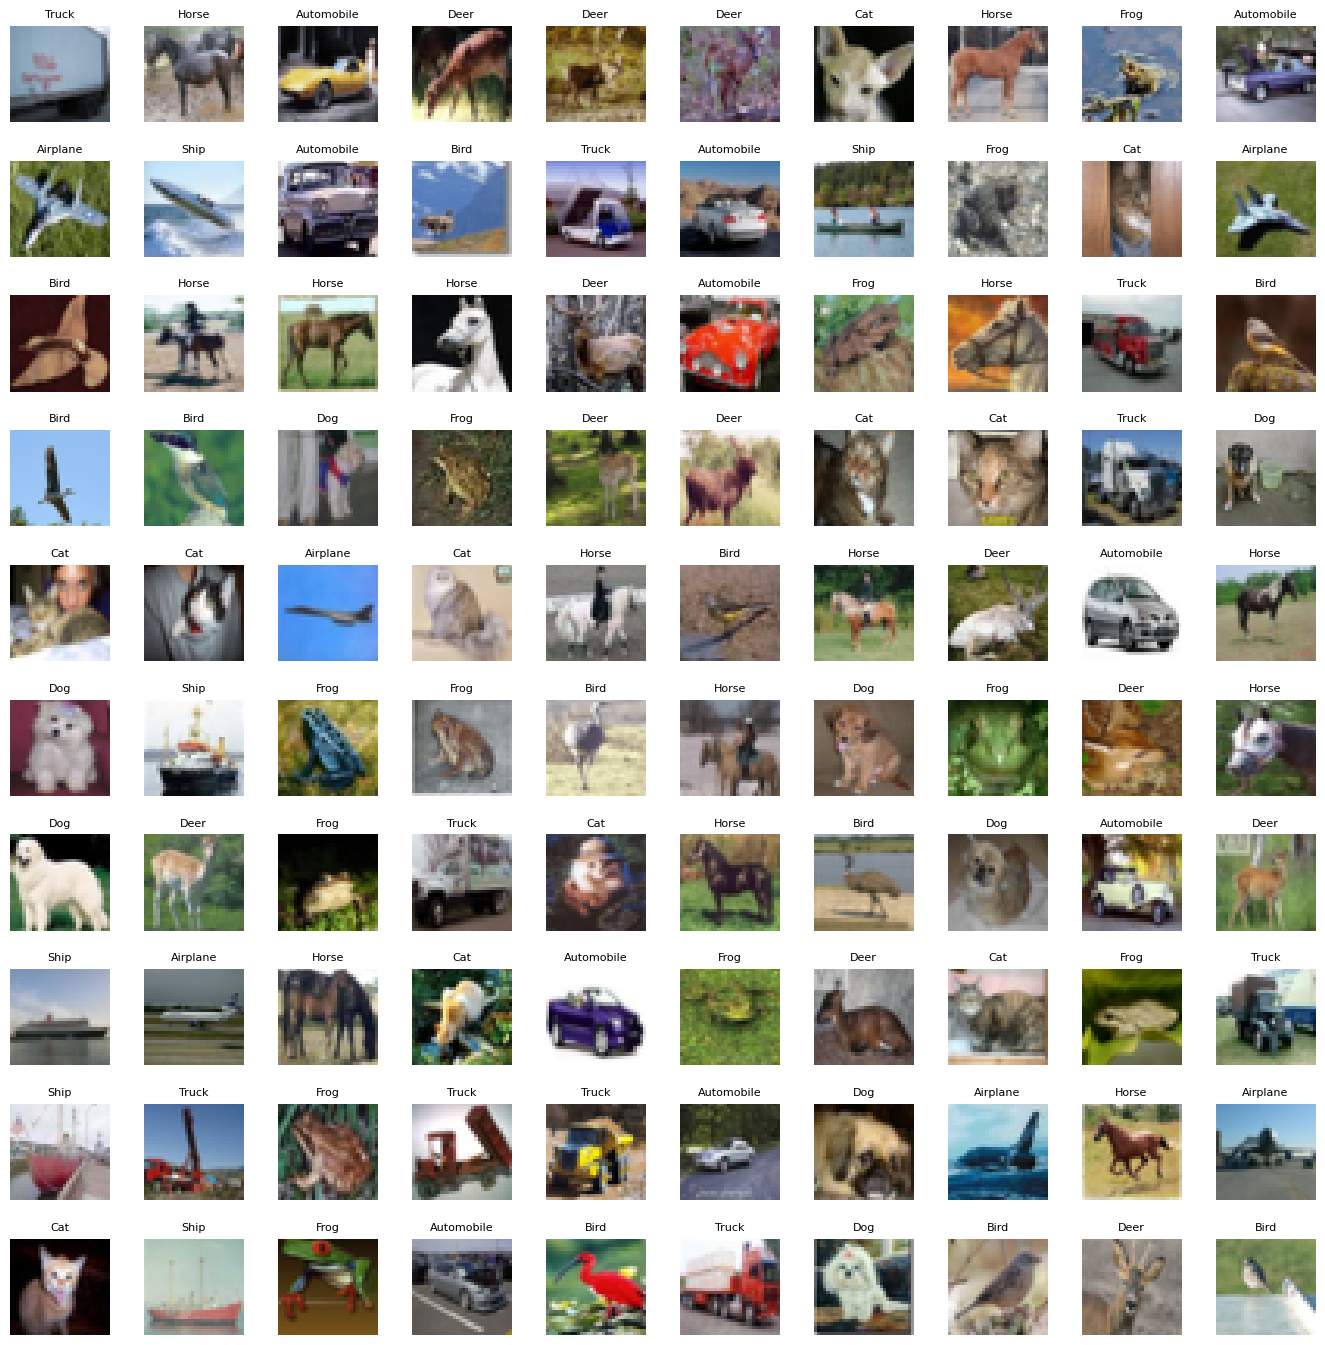

In [6]:
#Function to display data samples
def display_samples(x, y, classes_name):

          # Define the dimensions of the plot grid 
          W_grid = 10
          L_grid = 10
          
          # we can use the axes object to plot specific figures at various locations
          fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
          axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
          n_train = len(x) # get the length of the train dataset
          
          # Select a random number from 0 to n_train
          for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 
            index = np.random.randint(0, n_train) 
            axes[i].imshow(x[index,1:]) # read and display an image with the selected index
            label_index = int(y[index])
            axes[i].set_title(classes_name[label_index], fontsize = 8)
            axes[i].axis('off')

          plt.subplots_adjust(hspace=0.4)

display_samples(X_train, y_train, classes_name)

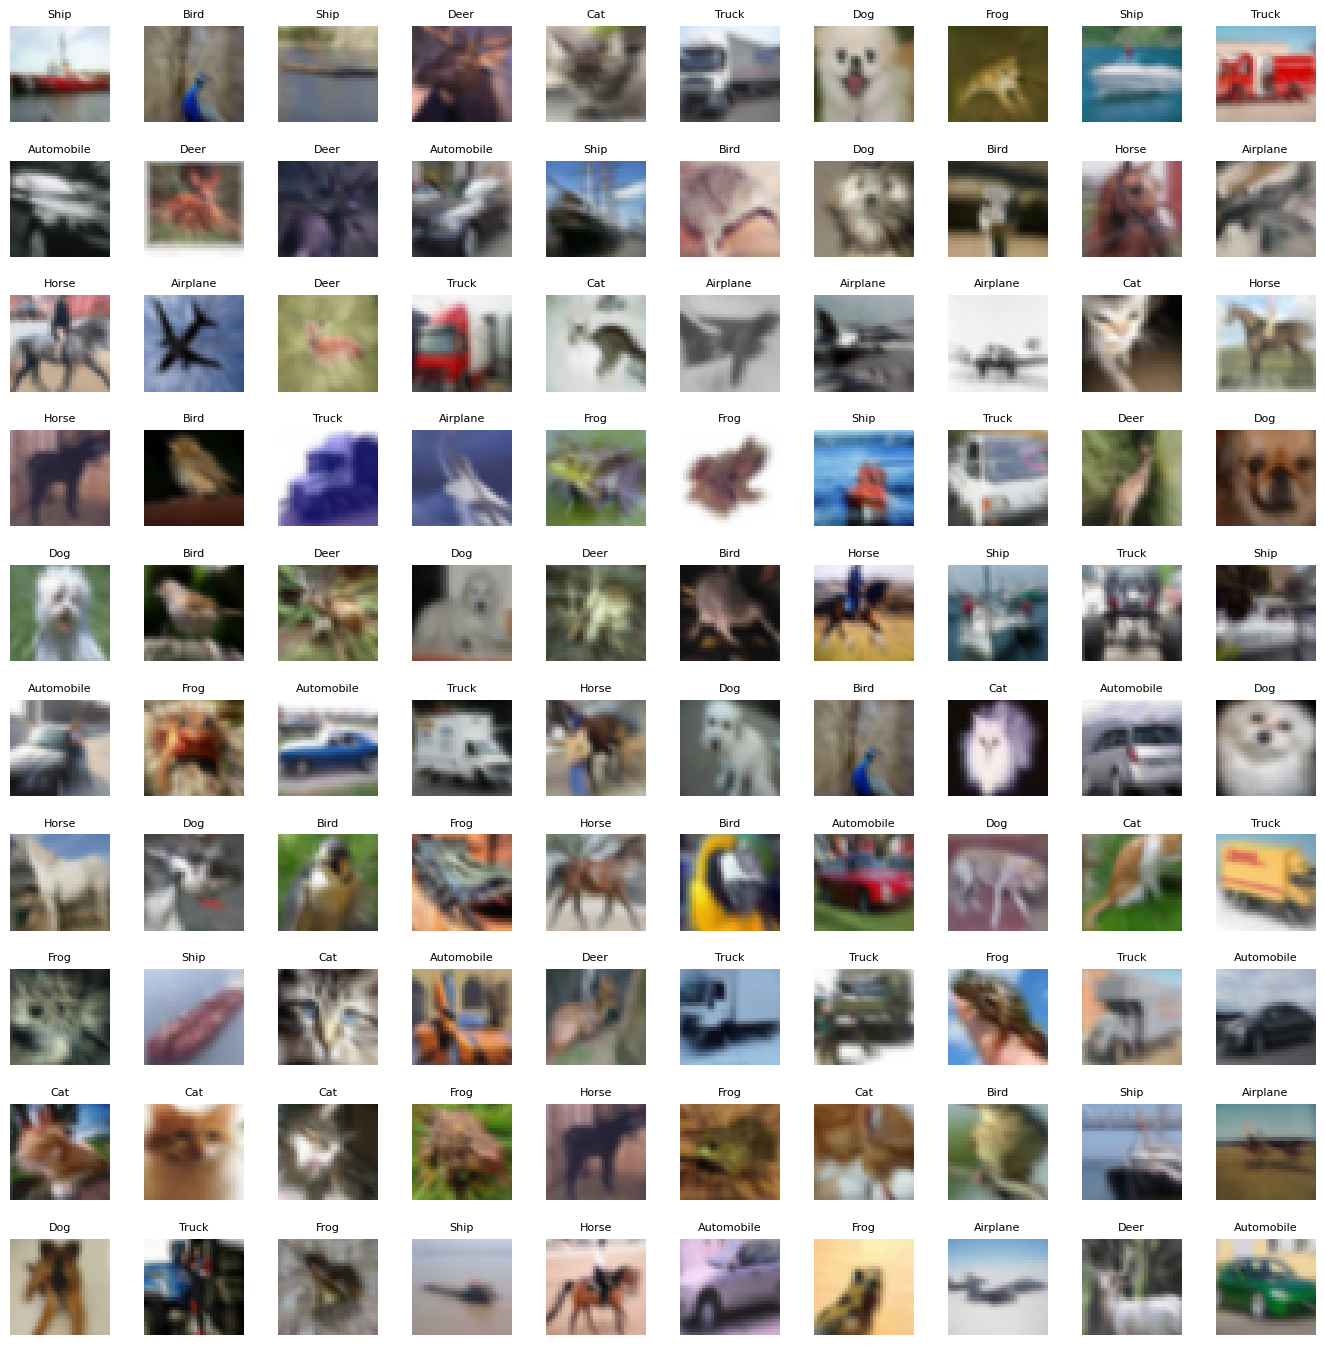

In [7]:
display_samples(x_zoom_blur, y_test, classes_name)

Text(0.5, 1.0, 'Class distribution in training set')

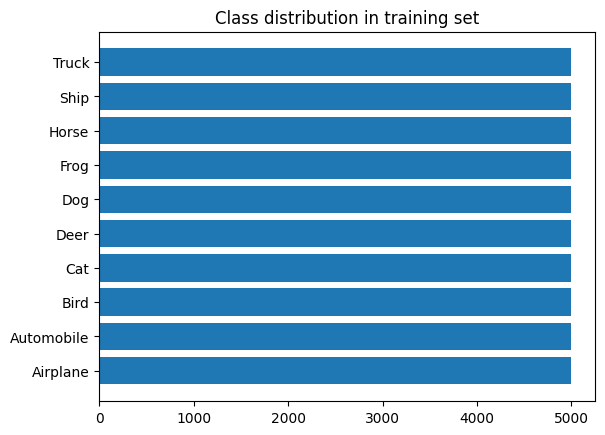

In [8]:
#Visualize class distribution

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')


Text(0.5, 1.0, 'Class distribution in clean testing set')

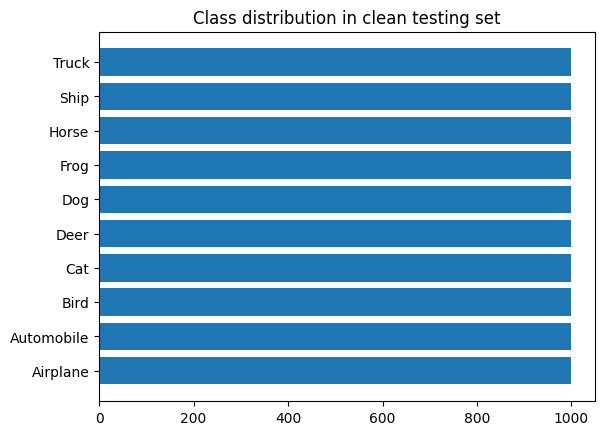

In [9]:
#Visualize class distribution

classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in clean testing set')


# One hot coding of label dataset

In [10]:
# Scale the data

X_train = X_train / 255.0
X_test = X_test / 255.0
x_gnoise = x_gnoise / 255.0
x_bright = x_bright / 255.0
x_contrast = x_contrast / 255.0
x_zoom_blur = x_zoom_blur / 255.0
x_gblur = x_gblur / 255.0

# Transform target variable into one-hotencoding

y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [11]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Loading pretrained models

In [12]:
#load pretrained models
vgg19_model = keras.models.load_model('drive/MyDrive/Colab Notebooks/Research Project/models/VGG19')
vgg16_model = keras.models.load_model('drive/MyDrive/Colab Notebooks/Research Project/models/VGG16')
resnet50_model = keras.models.load_model('drive/MyDrive/Colab Notebooks/Research Project/models/ResNet50')



#load pretrained faulty models
vgg19_fault = keras.models.load_model('drive/MyDrive/Colab Notebooks/Research Project/models/vgg19_fault')
vgg16_fault = keras.models.load_model('drive/MyDrive/Colab Notebooks/Research Project/models/vgg16_fault')
ResNet50_fault = keras.models.load_model('drive/MyDrive/Colab Notebooks/Research Project/models/ResNet50_fault')

In [13]:
#Function to generate confusion matrix
def CM(model, x, ycat_TEST, ytest):
  evaluation = model.evaluate(x, ycat_TEST)
  print(f'Test Accuracy of model : {evaluation[1] * 100:.2f}%')
  
  y_pred = model.predict(x)
  y_pred = np.argmax(y_pred, axis=1)
  global cm
  cm = confusion_matrix(ytest, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes_name)
  #print(cm)
  # NOTE: Fill all variables here with default values of the plot_confusion_matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='Greens')
  plt.grid(False)
  plt.show()   

In [14]:
'''
#Function to generate confusion matrix
def CM_color(model, x, ycat_TEST, ytest):
  evaluation = model.evaluate(x, ycat_TEST)
  print(f'Test Accuracy of model : {evaluation[1] * 100:.2f}%')
  
  y_pred = model.predict(x)
  y_pred = np.argmax(y_pred, axis=1)
  global cm_color
  cm_color = confusion_matrix(ytest, y_pred)

  vmin = np.min(cm_color)
  vmax = np.max(cm_color)
  off_diag_mask = np.eye(*cm_color.shape, dtype=int, order='C')

  fig = plt.figure()
  sns.heatmap(cm_color, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
  sns.heatmap(cm_color, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

  #disp = ConfusionMatrixDisplay(confusion_matrix=cm_color, display_labels=classes_name)
  #print(cm)
  # NOTE: Fill all variables here with default values of the plot_confusion_matrix
  #fig, ax = plt.subplots(figsize=(10, 10))
  #disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='Greens')
  #plt.grid(False)
  plt.show()   
'''

"\n#Function to generate confusion matrix\ndef CM_color(model, x, ycat_TEST, ytest):\n  evaluation = model.evaluate(x, ycat_TEST)\n  print(f'Test Accuracy of model : {evaluation[1] * 100:.2f}%')\n  \n  y_pred = model.predict(x)\n  y_pred = np.argmax(y_pred, axis=1)\n  global cm_color\n  cm_color = confusion_matrix(ytest, y_pred)\n\n  vmin = np.min(cm_color)\n  vmax = np.max(cm_color)\n  off_diag_mask = np.eye(*cm_color.shape, dtype=int, order='C')\n\n  fig = plt.figure()\n  sns.heatmap(cm_color, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)\n  sns.heatmap(cm_color, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))\n\n  #disp = ConfusionMatrixDisplay(confusion_matrix=cm_color, display_labels=classes_name)\n  #print(cm)\n  # NOTE: Fill all variables here with default values of the plot_confusion_matrix\n  #fig, ax = plt.subplots(figsize=(10, 10))\n  #disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='Greens')\n  #plt.

In [15]:
#clean_acc = evaluate_clean_data(vgg19_model, X_test)

In [114]:
#Function for Model Accuracy Evaluation

def accuracy(cm):
  confusion_matrix = tf.convert_to_tensor(cm)
  diagonal_sum = tf.linalg.trace(cm)
  total_sum = tf.reduce_sum(confusion_matrix)
  accuracy = tf.divide(diagonal_sum, total_sum)
  accuracy = tf.multiply(accuracy,100)
  accuracy = accuracy.numpy()
  return accuracy


#accuracy_clean = accuracy(cm)
#print(f'Accuracy of clean test data in %:', accuracy_clean)

In [115]:
image_corruptions = (x_zoom_blur, x_gblur, x_bright, x_gnoise, x_contrast)  #corrupted dataset list

#Lists to save paramter values
RLA_vgg16 = []
RLA_vgg19 = []
RLA_resnet50 = []

RLA_vgg16_fault = []
RLA_vgg19_fault = []
RLA_ResNet50_fault = []

ELA_vgg16 = []
ELA_vgg19 = []
ELA_resnet50 = []

ELA_vgg16_fault = []
ELA_vgg19_fault = []
ELA_ResNet50_fault = []

acc_vgg16 = []
acc_vgg19 = []
acc_resnet50 = []

acc_vgg16_fault = []
acc_vgg19_fault = []
acc_ResNet50_fault = []


#RLA = (accuracy(0%) - accuracy(x%)) / accuracy(0%)

def RLA(accuracy_clean, accuracy_corrupted, model):
  RLA_metric = (accuracy_clean - accuracy_corrupted) / accuracy_clean
  
  if model == vgg19_model:
    RLA_vgg19.append(RLA_metric*100)
  elif model == vgg16_model:
    RLA_vgg16.append(RLA_metric*100)
  elif model == resnet50_model:
    RLA_resnet50.append(RLA_metric*100)
  elif model == vgg19_fault:
    RLA_vgg19_fault.append(RLA_metric*100)
  elif model == vgg16_fault:
    RLA_vgg16_fault.append(RLA_metric*100)
  elif model == ResNet50_fault:
    RLA_ResNet50_fault.append(RLA_metric*100)
  return RLA_metric*100

#ELA = (100 - accuracy(x%)) / accuracy(0%)


def ELA(accuracy_clean, accuracy_corrupted, model):
  ELA_metric = (100 - accuracy_corrupted) / accuracy_clean
  
  if model == vgg19_model:
    ELA_vgg19.append(ELA_metric*100)
  elif model == vgg16_model:
    ELA_vgg16.append(ELA_metric*100)
  elif model == resnet50_model:
    ELA_resnet50.append(ELA_metric*100)
  elif model == vgg19_fault:
    ELA_vgg19_fault.append(ELA_metric*100)
  elif model == vgg16_fault:
    ELA_vgg16_fault.append(ELA_metric*100)
  elif model == ResNet50_fault:
    ELA_ResNet50_fault.append(ELA_metric*100)
  return ELA_metric*100

In [116]:
#Function to evaluate accuracy of model with Clean test data 

def evaluate_clean_data(model, x):
  CM(model, x, y_cat_test, y_test)
  accuracy_clean = accuracy(cm)
  print(f"Accuracy of clean data in % =", accuracy_clean)
  return accuracy_clean

#Function to evaluate accuracy, RLA and ELA of model with corrupted test data 

def evaluate_corr_data(model, x):
  CM(model, x, y_cat_test, y_test)
  accuracy_corr = accuracy(cm)
  print(f"Accuracy of =", accuracy_corr)
  if model == vgg19_model:
    acc_vgg19.append(accuracy_corr)
  elif model == vgg16_model:
    acc_vgg16.append(accuracy_corr)
  elif model == resnet50_model:
    acc_resnet50.append(accuracy_corr)
  elif model == vgg19_fault:
    acc_vgg19_fault.append(accuracy_corr)
  elif model == vgg16_fault:
    acc_vgg16_fault.append(accuracy_corr)
  elif model == ResNet50_fault:
    acc_ResNet50_fault.append(accuracy_corr)
  rla = RLA(clean_acc, accuracy_corr, model)
  ela = ELA(clean_acc, accuracy_corr, model)
  print(f"RLA =", rla)
  print(f"\n" + "ELA =", ela)
  return rla, ela 

# **Evaluation of VGG19 on clean and corrupted test data**

In [117]:
'''
def Evaluate(model):
  clean_acc = evaluate_clean_data(vgg19_model, X_test)
  
  for i in image_corruptions:
    evaluate_corr_data(model, i)
    i=+1
'''

'\ndef Evaluate(model):\n  clean_acc = evaluate_clean_data(vgg19_model, X_test)\n  \n  for i in image_corruptions:\n    evaluate_corr_data(model, i)\n    i=+1\n'

313/313 [==============================] - 4s 12ms/step - loss: 0.6612 - accuracy: 0.8095 - precision: 0.8529 - recall: 0.7767
Test Accuracy of model : 80.95%
313/313 [==============================] - 3s 9ms/step


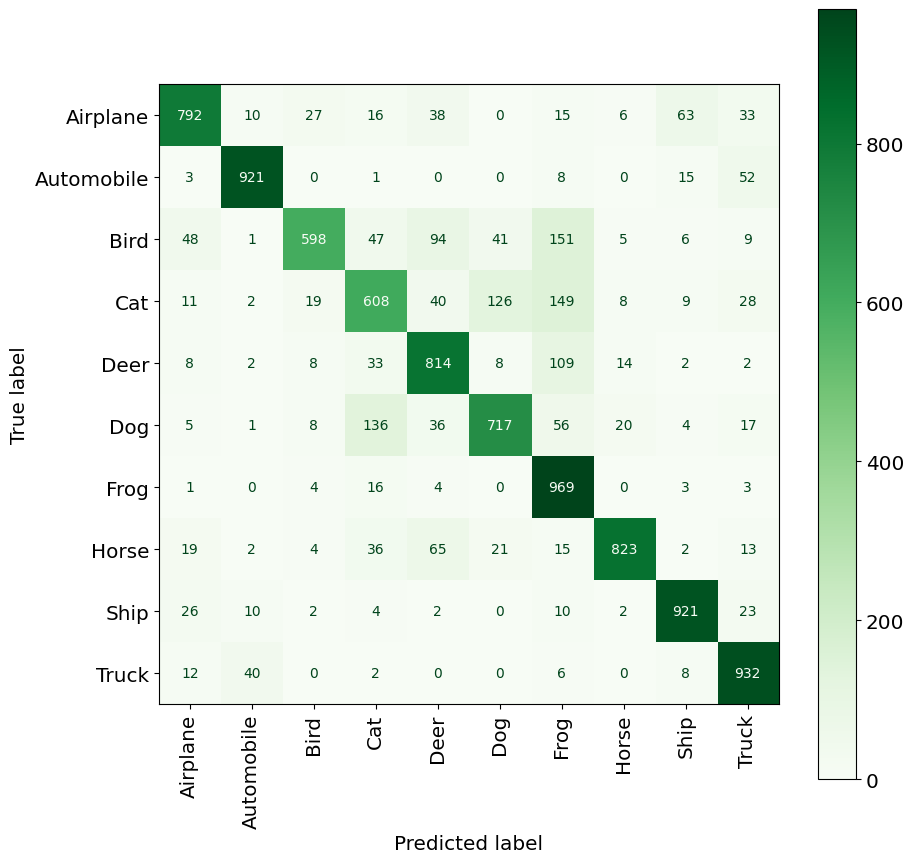

Accuracy of clean data in % = 80.95
313/313 [==============================] - 3s 11ms/step - loss: 0.8548 - accuracy: 0.7289 - precision: 0.8058 - recall: 0.6737
Test Accuracy of model : 72.89%
313/313 [==============================] - 3s 9ms/step


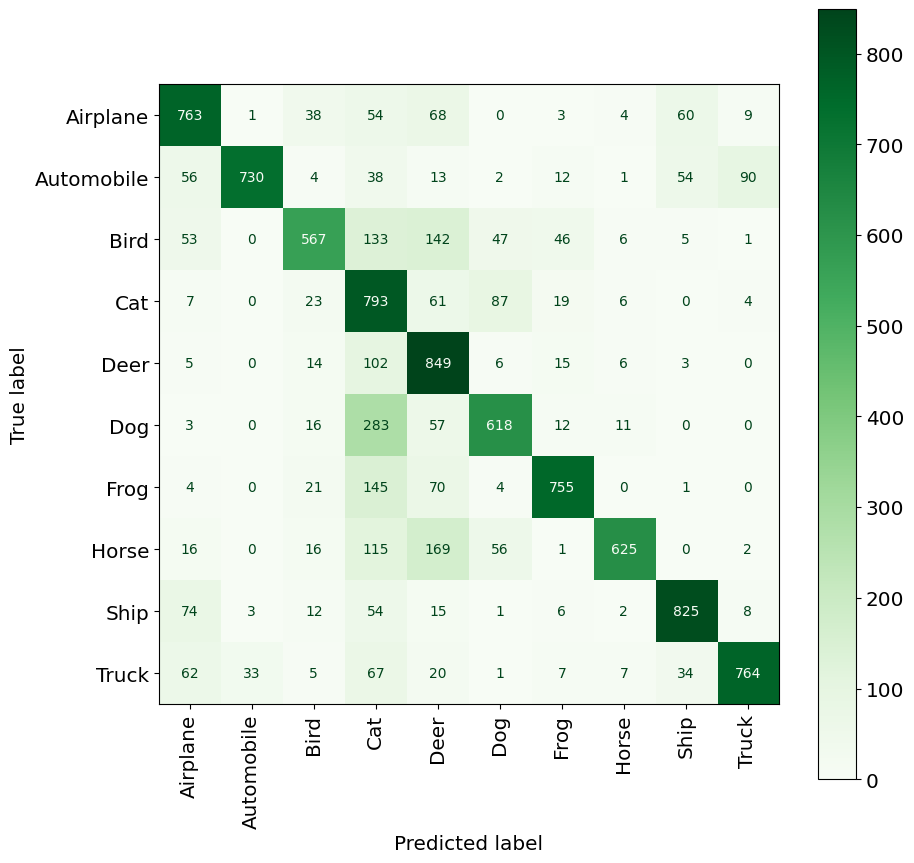

Accuracy of = 72.89
RLA = 9.956763434218656

ELA = 33.489808523780106
313/313 [==============================] - 4s 11ms/step - loss: 1.0319 - accuracy: 0.6781 - precision: 0.7531 - recall: 0.6147
Test Accuracy of model : 67.81%
313/313 [==============================] - 3s 9ms/step


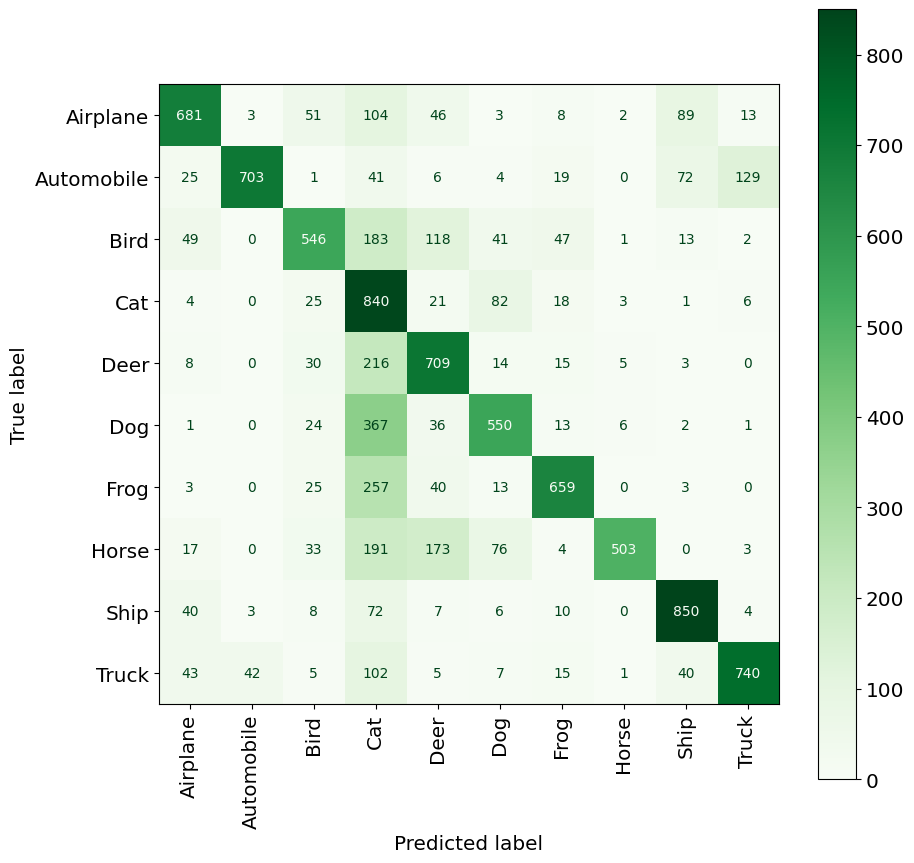

Accuracy of = 67.81
RLA = 16.232242124768376

ELA = 39.76528721432983
313/313 [==============================] - 4s 12ms/step - loss: 0.7263 - accuracy: 0.7787 - precision: 0.8328 - recall: 0.7393
Test Accuracy of model : 77.87%
313/313 [==============================] - 3s 9ms/step


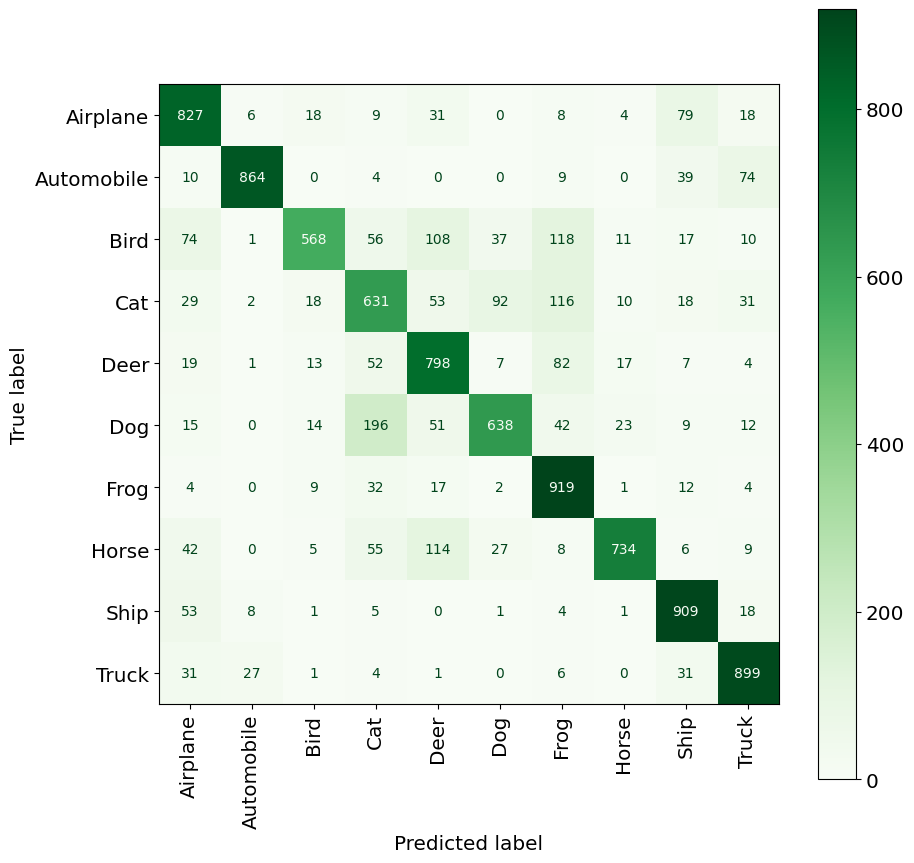

Accuracy of = 77.86999999999999
RLA = 3.8048177887585086

ELA = 27.337862878319964
313/313 [==============================] - 4s 12ms/step - loss: 2.2388 - accuracy: 0.5048 - precision: 0.5449 - recall: 0.4623
Test Accuracy of model : 50.48%
313/313 [==============================] - 3s 9ms/step


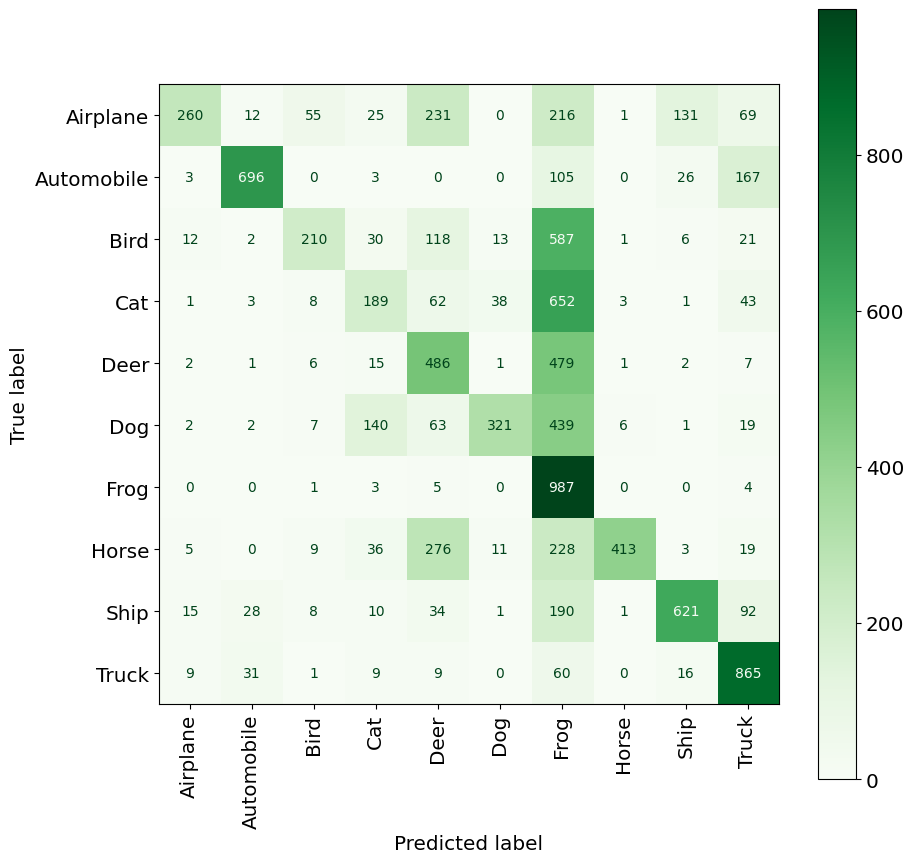

Accuracy of = 50.480000000000004
RLA = 37.64051883878937

ELA = 61.17356392835083
313/313 [==============================] - 4s 12ms/step - loss: 2.4710 - accuracy: 0.2601 - precision: 0.3215 - recall: 0.1755
Test Accuracy of model : 26.01%
313/313 [==============================] - 3s 9ms/step


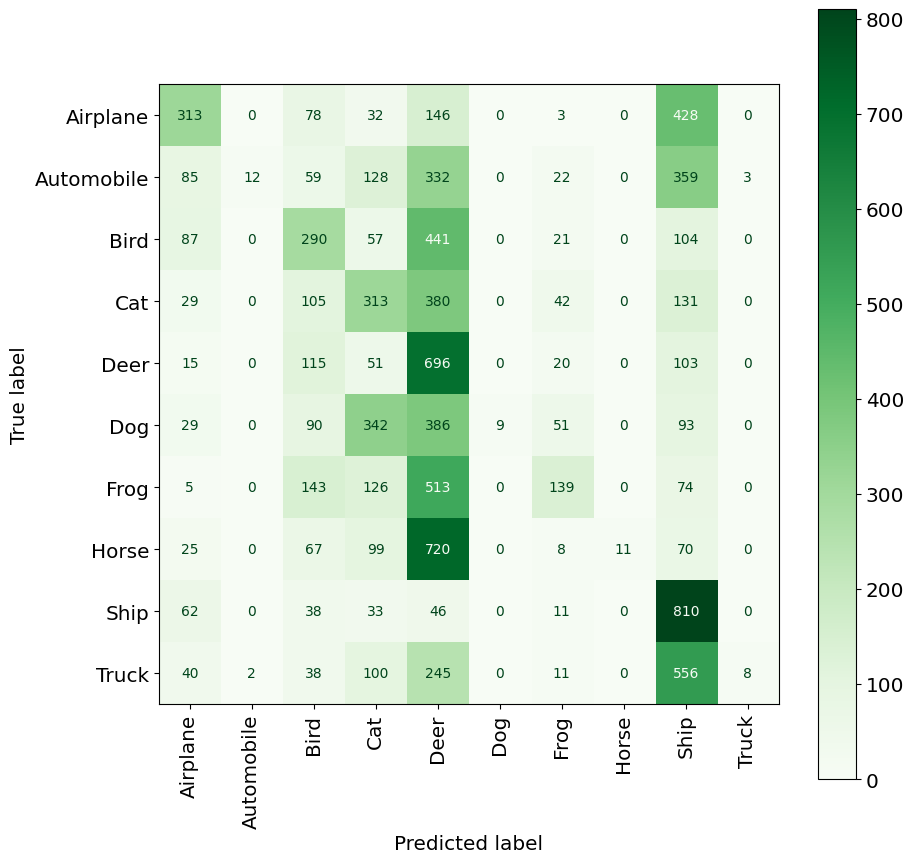

Accuracy of = 26.009999999999998
RLA = 67.86905497220506

ELA = 91.40210006176653


In [118]:
clean_acc = evaluate_clean_data(vgg19_model, X_test)

for i in image_corruptions:
  evaluate_corr_data(vgg19_model, i)
  i=+1

# **Evaluation of faulty VGG19 on clean and corrupted test data**

313/313 [==============================] - 3s 11ms/step - loss: 0.9204 - accuracy: 0.6909 - precision: 0.8215 - recall: 0.5757
Test Accuracy of model : 69.09%
313/313 [==============================] - 3s 9ms/step


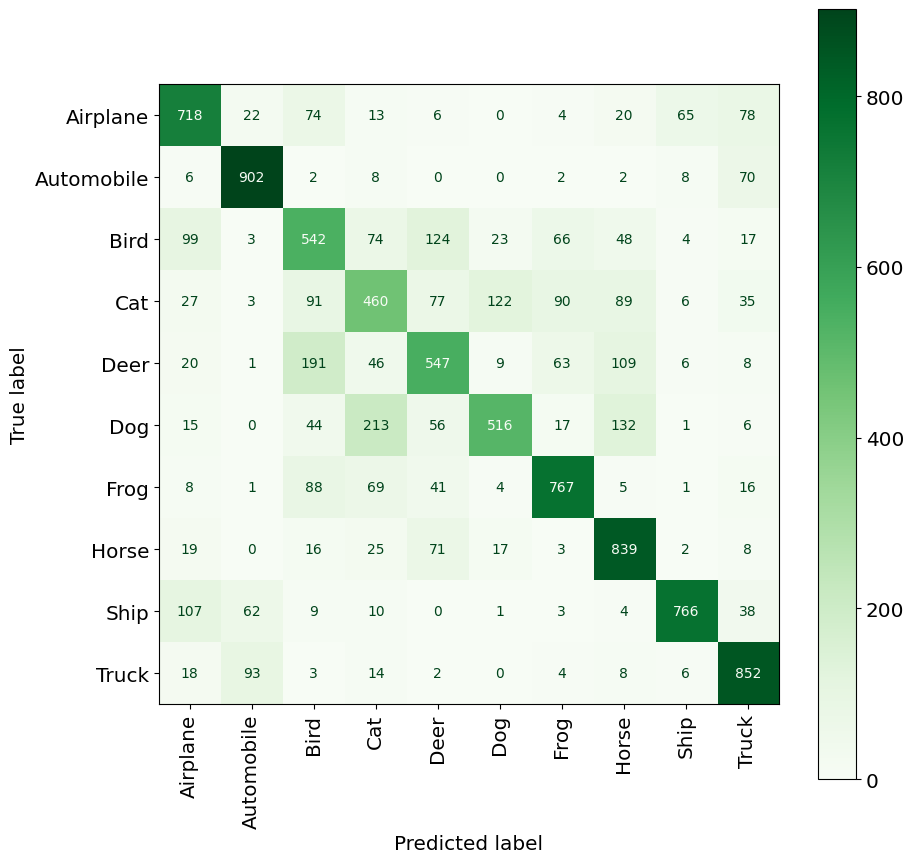

Accuracy of clean data in % = 69.08999999999999
313/313 [==============================] - 4s 11ms/step - loss: 1.2311 - accuracy: 0.5850 - precision: 0.7565 - recall: 0.4430
Test Accuracy of model : 58.50%
313/313 [==============================] - 3s 9ms/step


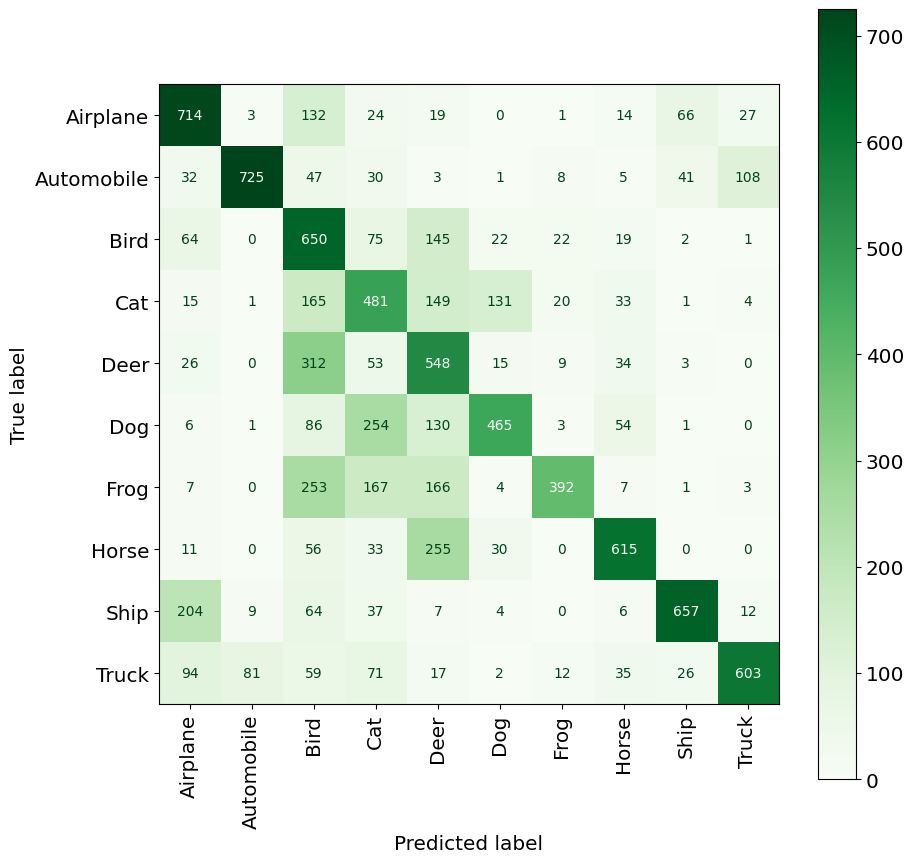

Accuracy of = 58.5
RLA = 15.327833260963947

ELA = 60.06657982341874
313/313 [==============================] - 4s 11ms/step - loss: 1.2633 - accuracy: 0.5637 - precision: 0.7349 - recall: 0.4036
Test Accuracy of model : 56.37%
313/313 [==============================] - 3s 9ms/step


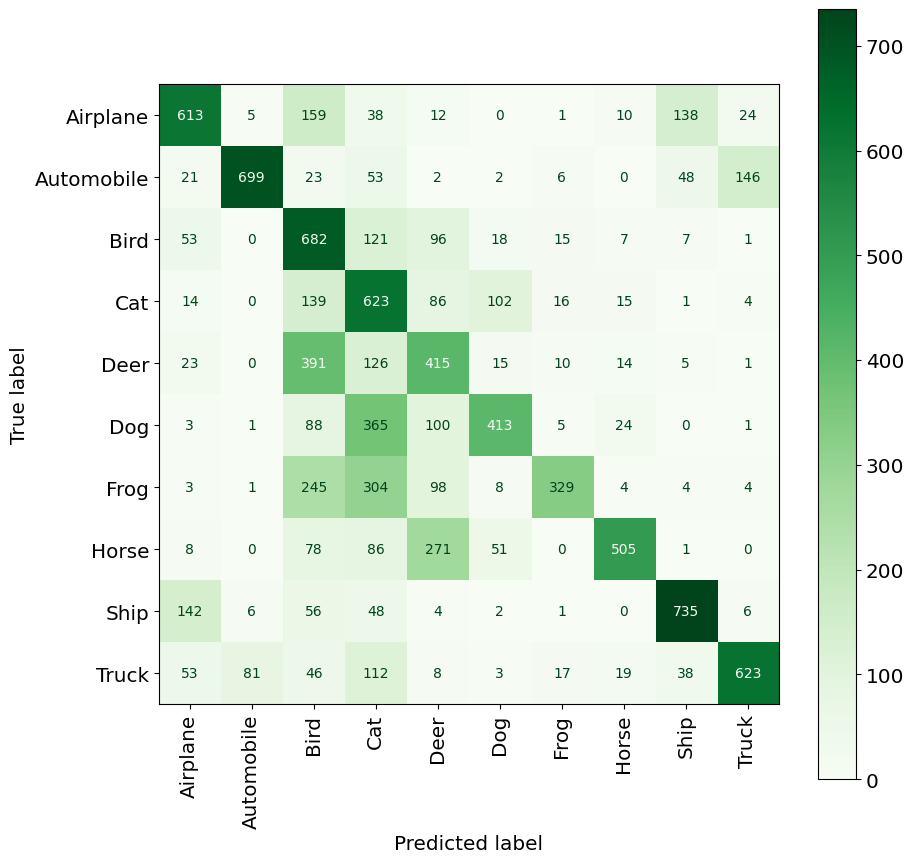

Accuracy of = 56.37
RLA = 18.410768562744238

ELA = 63.14951512519903
313/313 [==============================] - 4s 11ms/step - loss: 1.0244 - accuracy: 0.6526 - precision: 0.8048 - recall: 0.5248
Test Accuracy of model : 65.26%
313/313 [==============================] - 3s 9ms/step


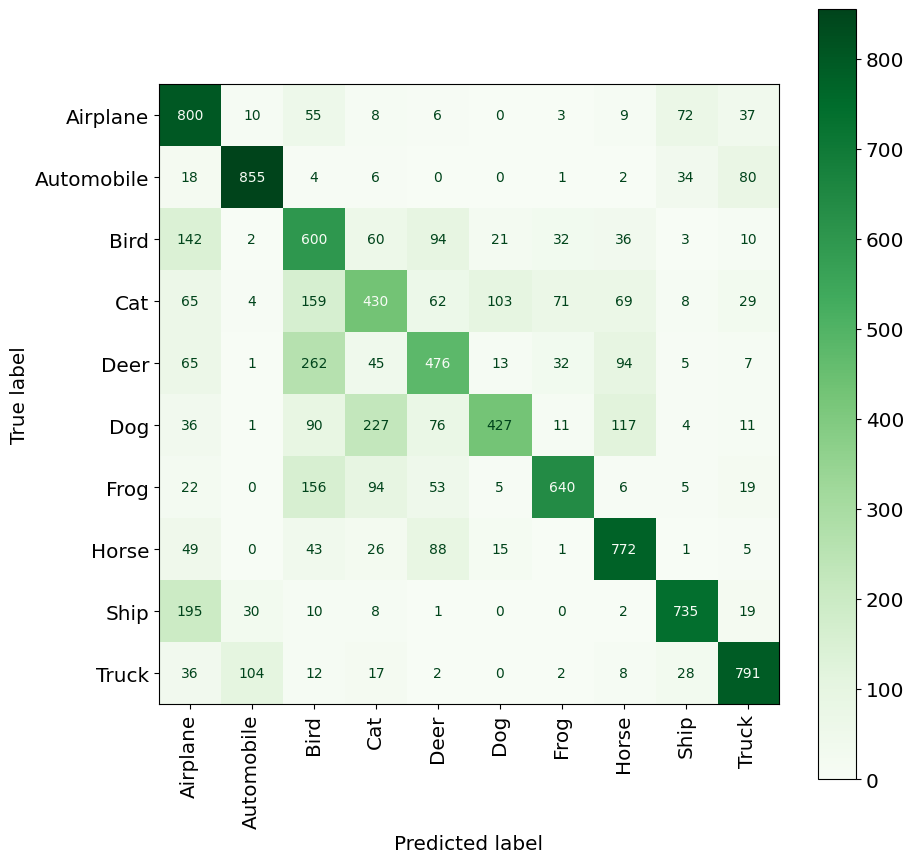

Accuracy of = 65.25999999999999
RLA = 5.543493993342016

ELA = 50.28224055579681
313/313 [==============================] - 4s 12ms/step - loss: 1.4241 - accuracy: 0.5176 - precision: 0.6659 - recall: 0.3964
Test Accuracy of model : 51.76%
313/313 [==============================] - 3s 9ms/step


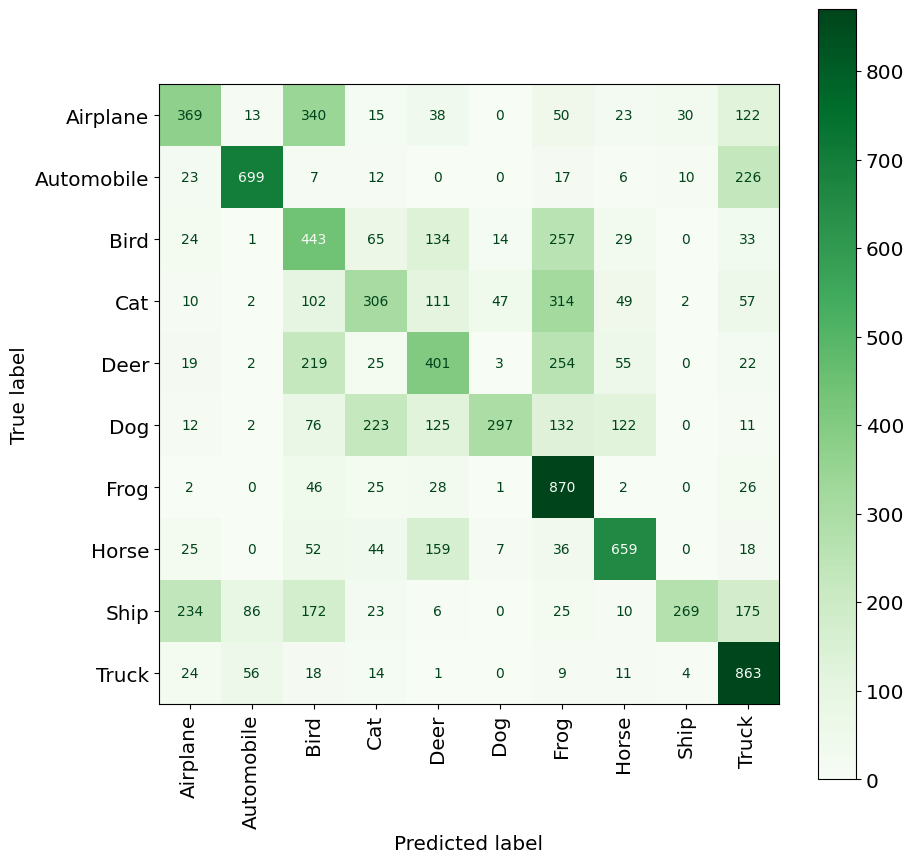

Accuracy of = 51.76
RLA = 25.083224779273404

ELA = 69.8219713417282
313/313 [==============================] - 4s 12ms/step - loss: 2.9447 - accuracy: 0.2056 - precision: 0.2652 - recall: 0.1563
Test Accuracy of model : 20.56%
313/313 [==============================] - 3s 9ms/step


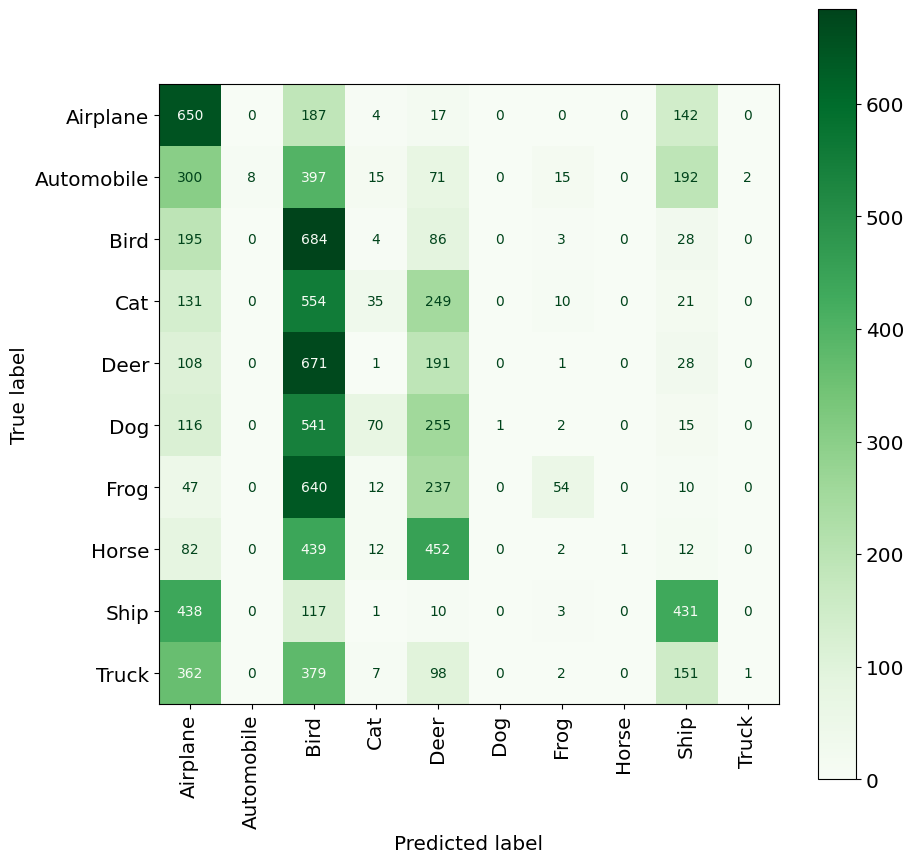

Accuracy of = 20.560000000000002
RLA = 70.24171370675928

ELA = 114.98046026921409


In [119]:
clean_acc = evaluate_clean_data(vgg19_fault, X_test)

for i in image_corruptions:
  evaluate_corr_data(vgg19_fault, i)
  i=+1

## **Evaluation of VGG16 on clean and corrupted test data**

313/313 [==============================] - 3s 10ms/step - loss: 0.4951 - accuracy: 0.8594 - precision: 0.8877 - recall: 0.8381
Test Accuracy of model : 85.94%
313/313 [==============================] - 2s 7ms/step


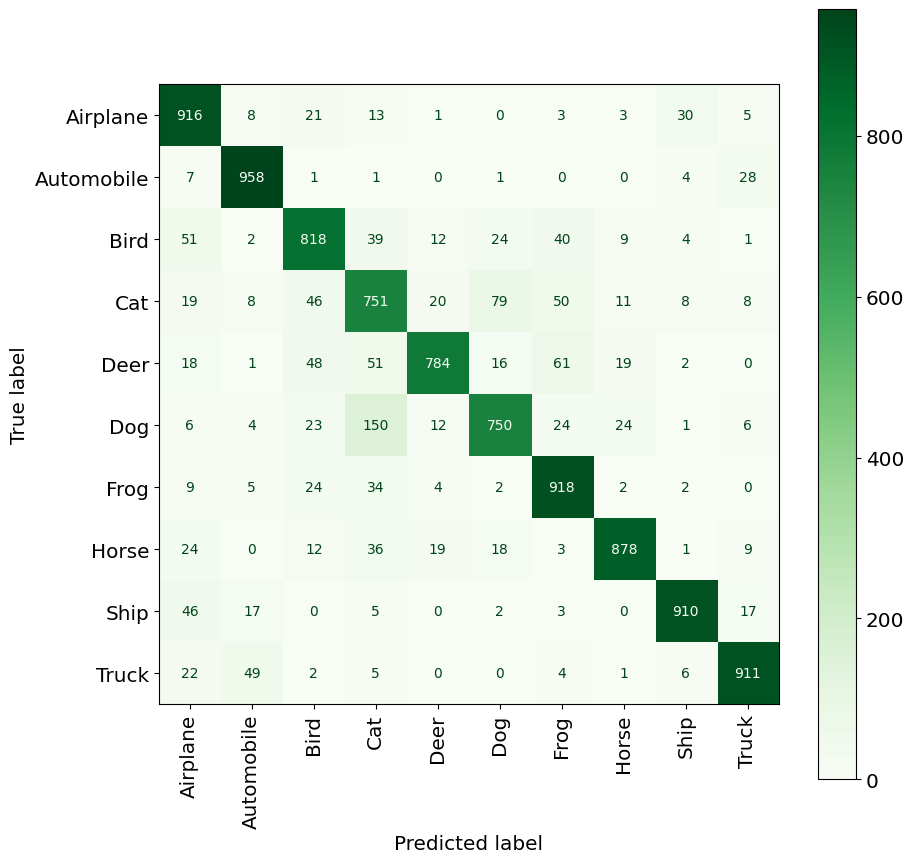

Accuracy of clean data in % = 85.94000000000001
313/313 [==============================] - 3s 10ms/step - loss: 0.7991 - accuracy: 0.7676 - precision: 0.8174 - recall: 0.7317
Test Accuracy of model : 76.76%
313/313 [==============================] - 2s 7ms/step


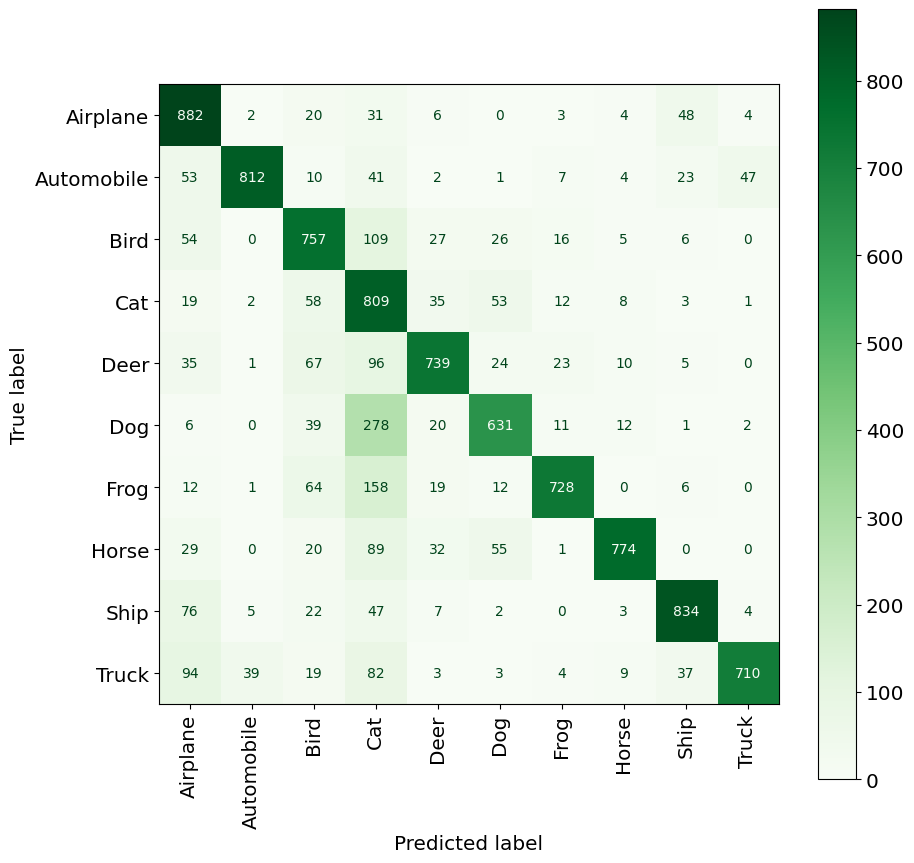

Accuracy of = 76.75999999999999
RLA = 10.68187107284154

ELA = 27.042122410984415
313/313 [==============================] - 3s 9ms/step - loss: 1.0621 - accuracy: 0.7025 - precision: 0.7561 - recall: 0.6618
Test Accuracy of model : 70.25%
313/313 [==============================] - 2s 8ms/step


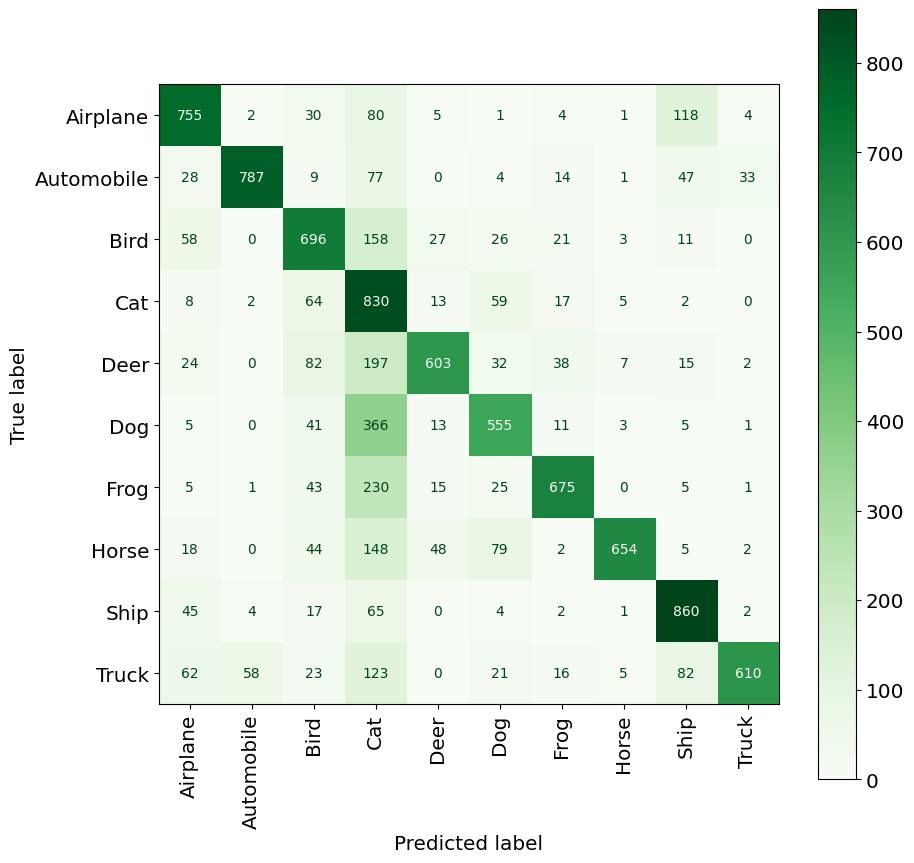

Accuracy of = 70.25
RLA = 18.25692343495463

ELA = 34.6171747730975
313/313 [==============================] - 3s 9ms/step - loss: 0.6089 - accuracy: 0.8206 - precision: 0.8542 - recall: 0.7986
Test Accuracy of model : 82.06%
313/313 [==============================] - 2s 7ms/step


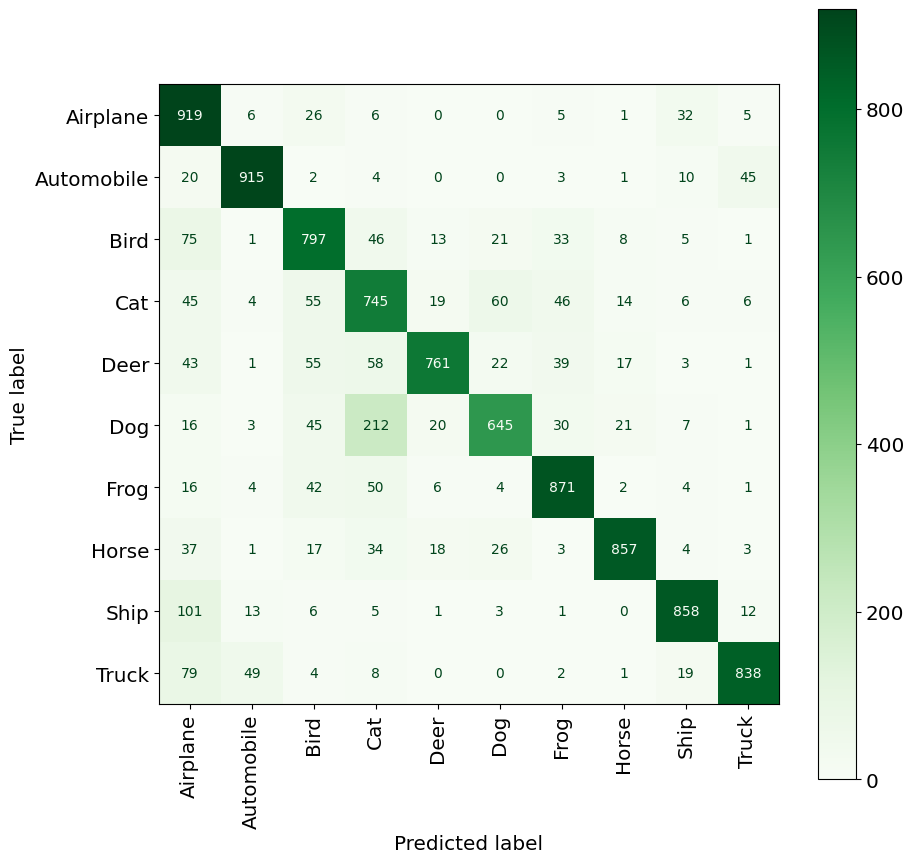

Accuracy of = 82.06
RLA = 4.514777751919954

ELA = 20.87502909006283
313/313 [==============================] - 3s 10ms/step - loss: 1.3727 - accuracy: 0.6262 - precision: 0.6874 - recall: 0.5840
Test Accuracy of model : 62.62%
313/313 [==============================] - 2s 8ms/step


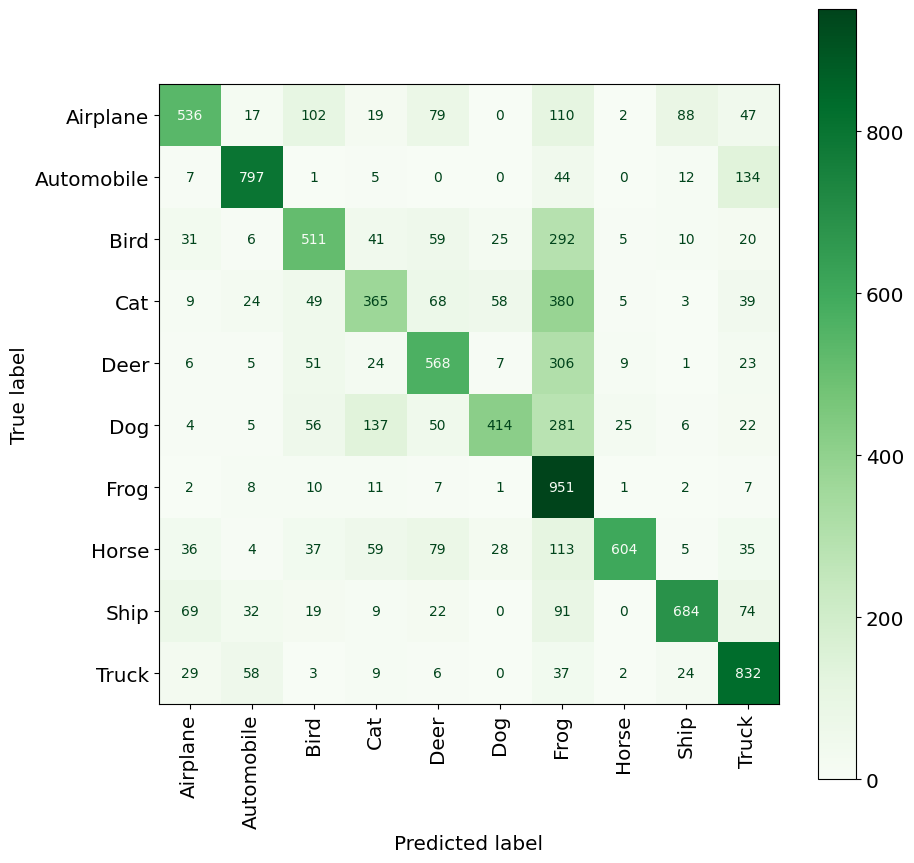

Accuracy of = 62.62
RLA = 27.135210612054934

ELA = 43.495461950197814
313/313 [==============================] - 3s 10ms/step - loss: 2.4560 - accuracy: 0.3331 - precision: 0.4325 - recall: 0.2509
Test Accuracy of model : 33.31%
313/313 [==============================] - 2s 7ms/step


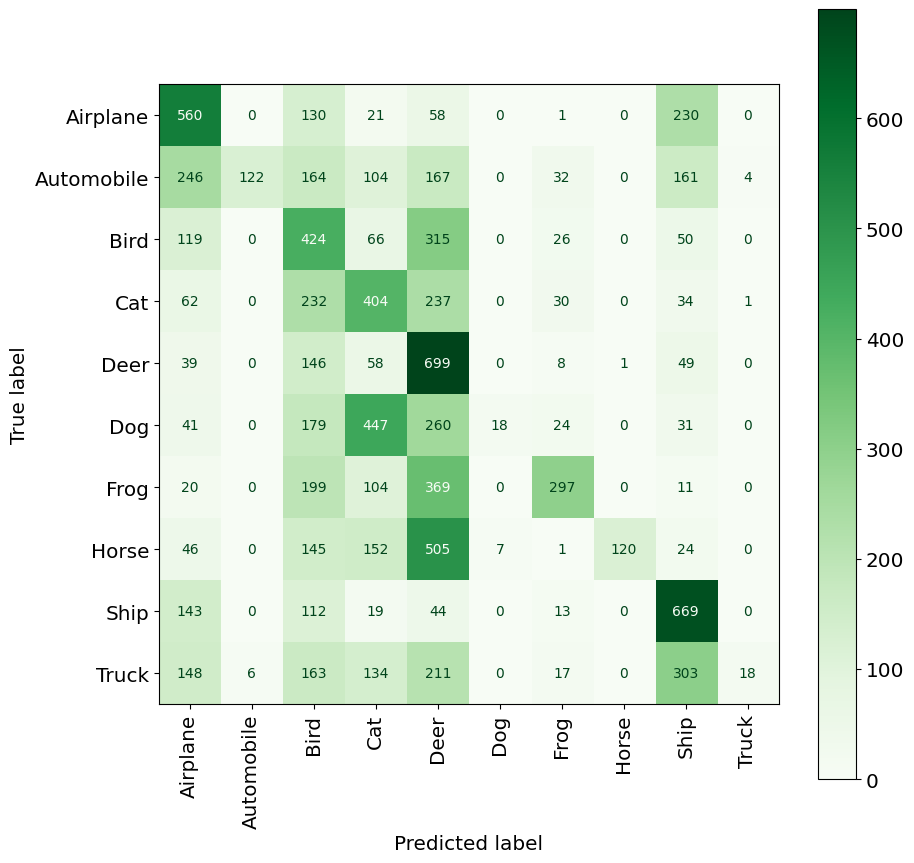

Accuracy of = 33.31
RLA = 61.240400279264605

ELA = 77.60065161740748


In [120]:
clean_acc = evaluate_clean_data(vgg16_model, X_test)

for i in image_corruptions:
  evaluate_corr_data(vgg16_model, i)
  i=+1

## **Evaluation of faulty VGG16 on clean and corrupted test data**

313/313 [==============================] - 3s 10ms/step - loss: 0.8268 - accuracy: 0.7281 - precision: 0.8198 - recall: 0.6542
Test Accuracy of model : 72.81%
313/313 [==============================] - 2s 7ms/step


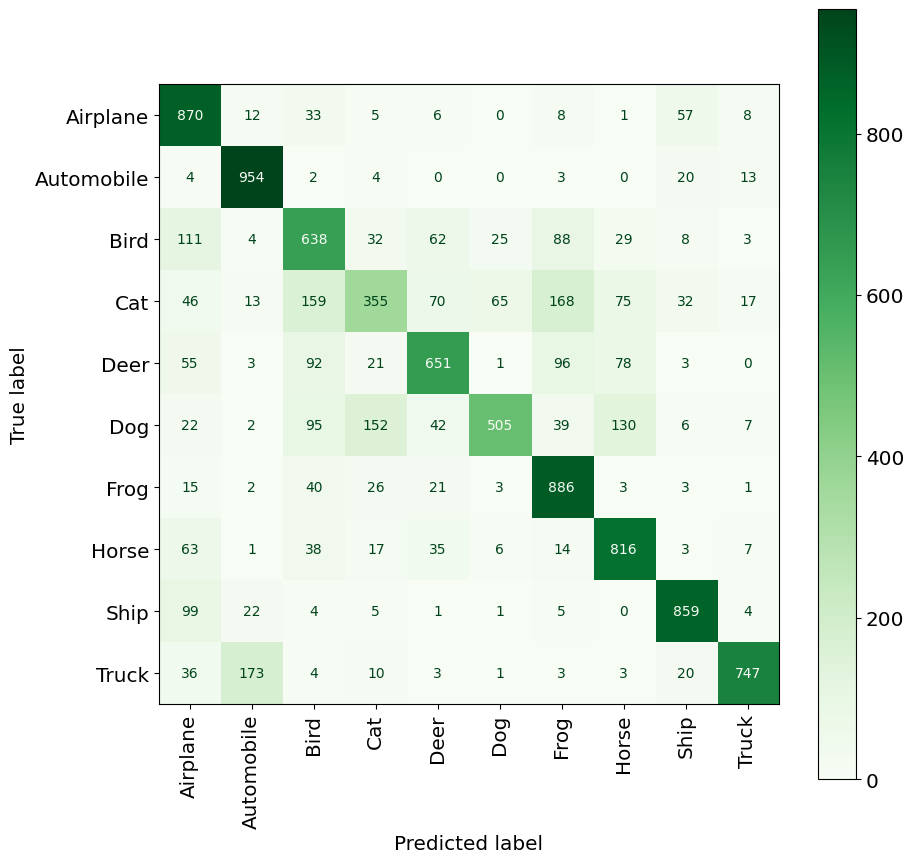

Accuracy of clean data in % = 72.81
313/313 [==============================] - 3s 9ms/step - loss: 1.1274 - accuracy: 0.6339 - precision: 0.7831 - recall: 0.5077
Test Accuracy of model : 63.39%
313/313 [==============================] - 2s 7ms/step


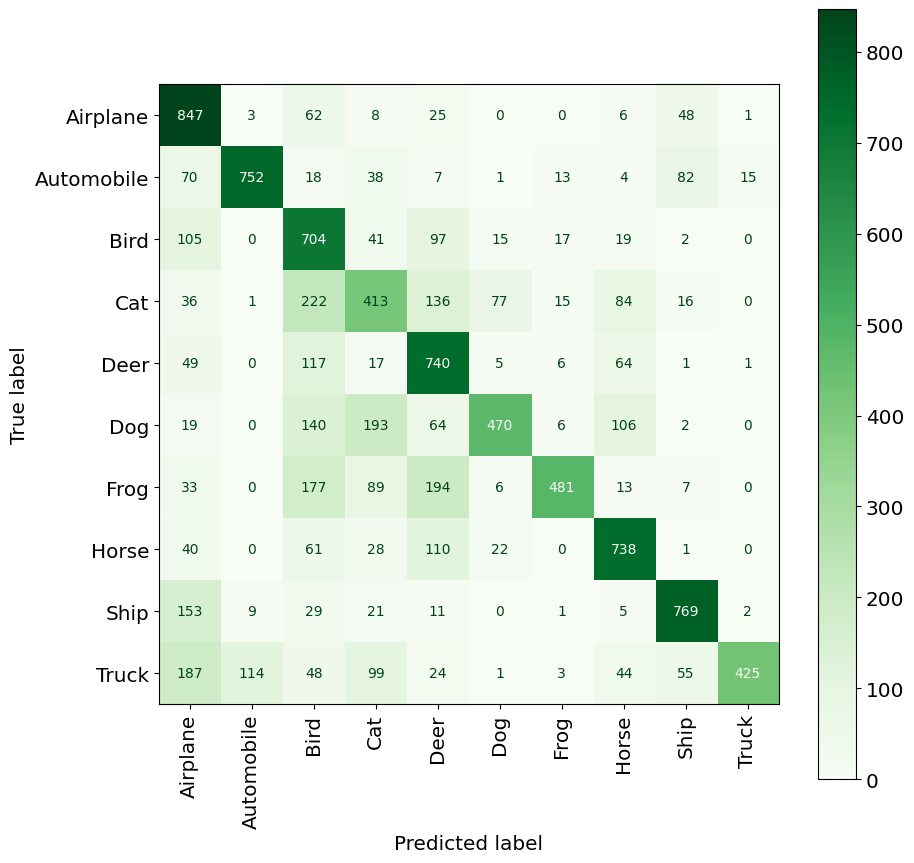

Accuracy of = 63.39
RLA = 12.93778327152864

ELA = 50.281554731492925
313/313 [==============================] - 3s 10ms/step - loss: 1.1724 - accuracy: 0.6139 - precision: 0.7906 - recall: 0.4575
Test Accuracy of model : 61.39%
313/313 [==============================] - 2s 7ms/step


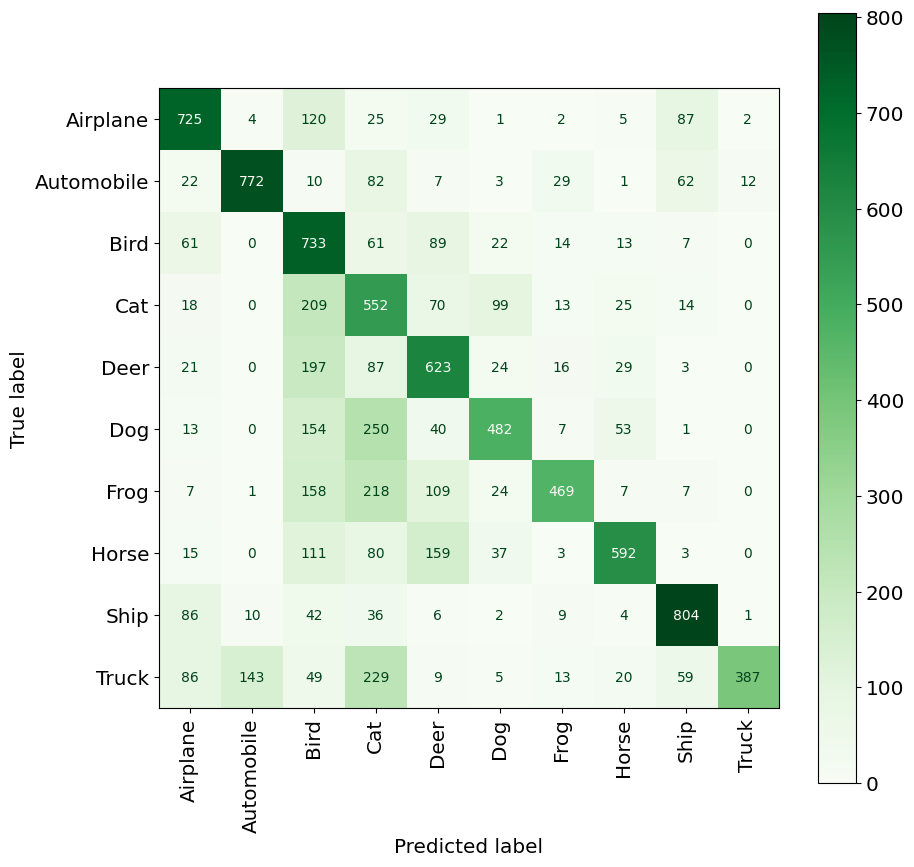

Accuracy of = 61.39
RLA = 15.684658700727924

ELA = 53.02843016069221
313/313 [==============================] - 3s 9ms/step - loss: 0.9440 - accuracy: 0.6933 - precision: 0.7932 - recall: 0.6083
Test Accuracy of model : 69.33%
313/313 [==============================] - 2s 7ms/step


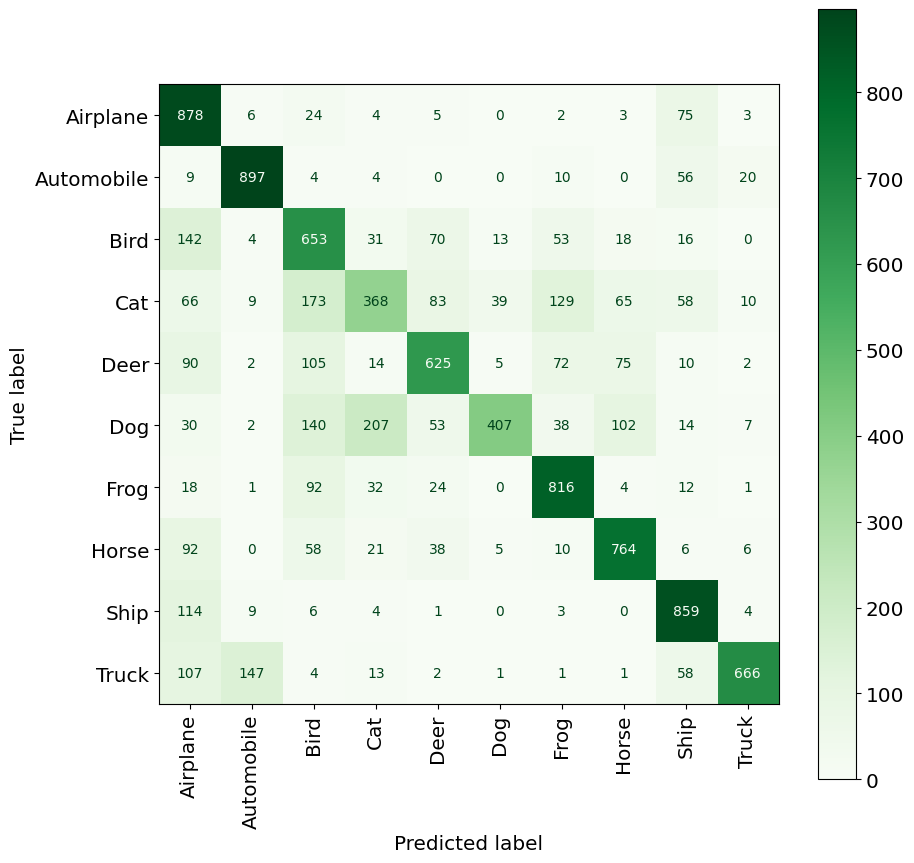

Accuracy of = 69.33
RLA = 4.779563246806762

ELA = 42.12333470677105
313/313 [==============================] - 3s 10ms/step - loss: 1.7223 - accuracy: 0.5094 - precision: 0.5982 - recall: 0.4168
Test Accuracy of model : 50.94%
313/313 [==============================] - 2s 7ms/step


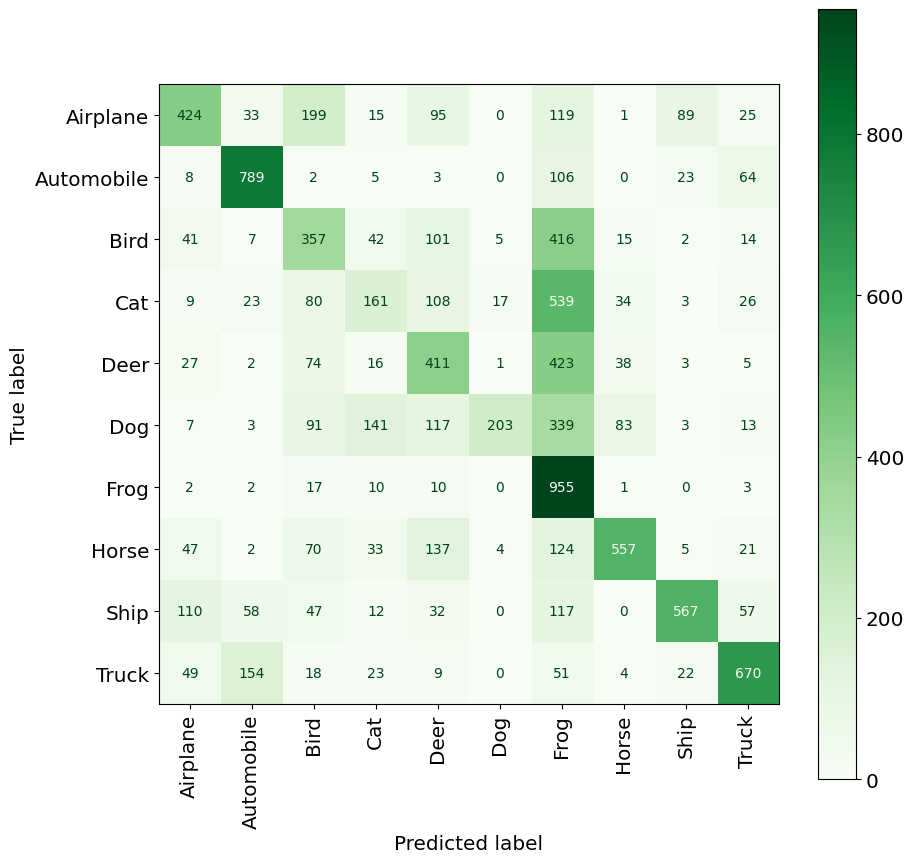

Accuracy of = 50.94
RLA = 30.0370828182942

ELA = 67.38085427825848
313/313 [==============================] - 3s 10ms/step - loss: 2.8205 - accuracy: 0.2318 - precision: 0.2794 - recall: 0.1721
Test Accuracy of model : 23.18%
313/313 [==============================] - 3s 8ms/step


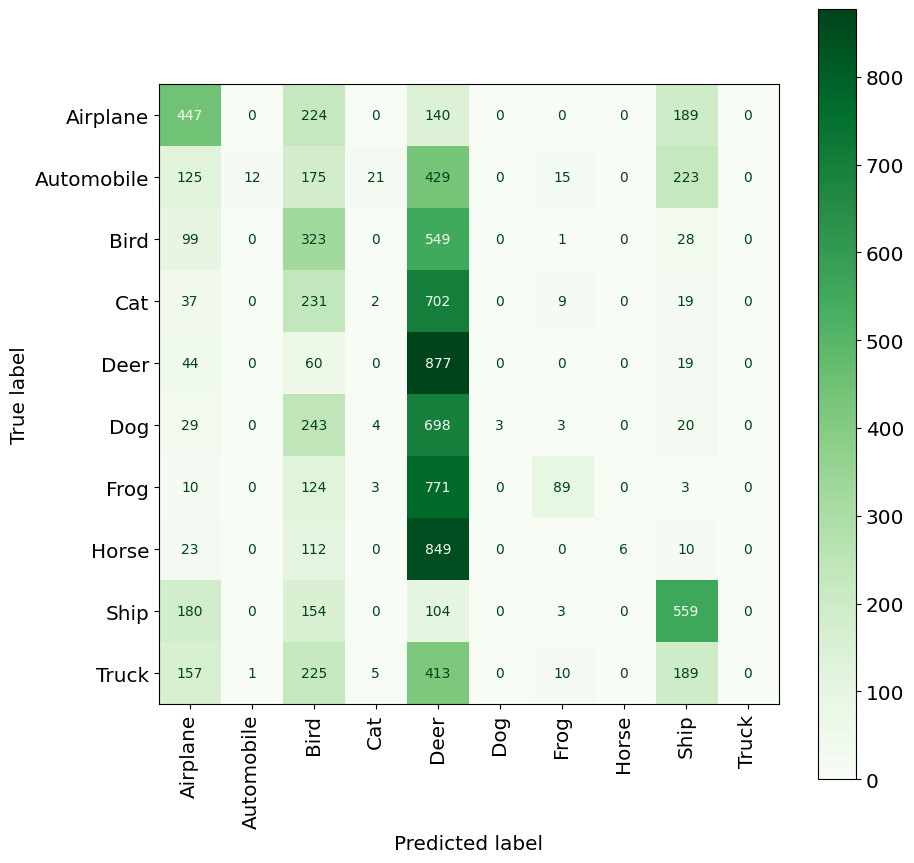

Accuracy of = 23.18
RLA = 68.16371377558028

ELA = 105.50748523554456


In [121]:
clean_acc = evaluate_clean_data(vgg16_fault, X_test)

for i in image_corruptions:
  evaluate_corr_data(vgg16_fault, i)
  i=+1

# **Evaluation of RESNET50 on clean and corrupted test data**

313/313 [==============================] - 4s 12ms/step - loss: 0.5754 - accuracy: 0.8244 - precision: 0.8483 - recall: 0.8097
Test Accuracy of model : 82.44%
313/313 [==============================] - 3s 9ms/step


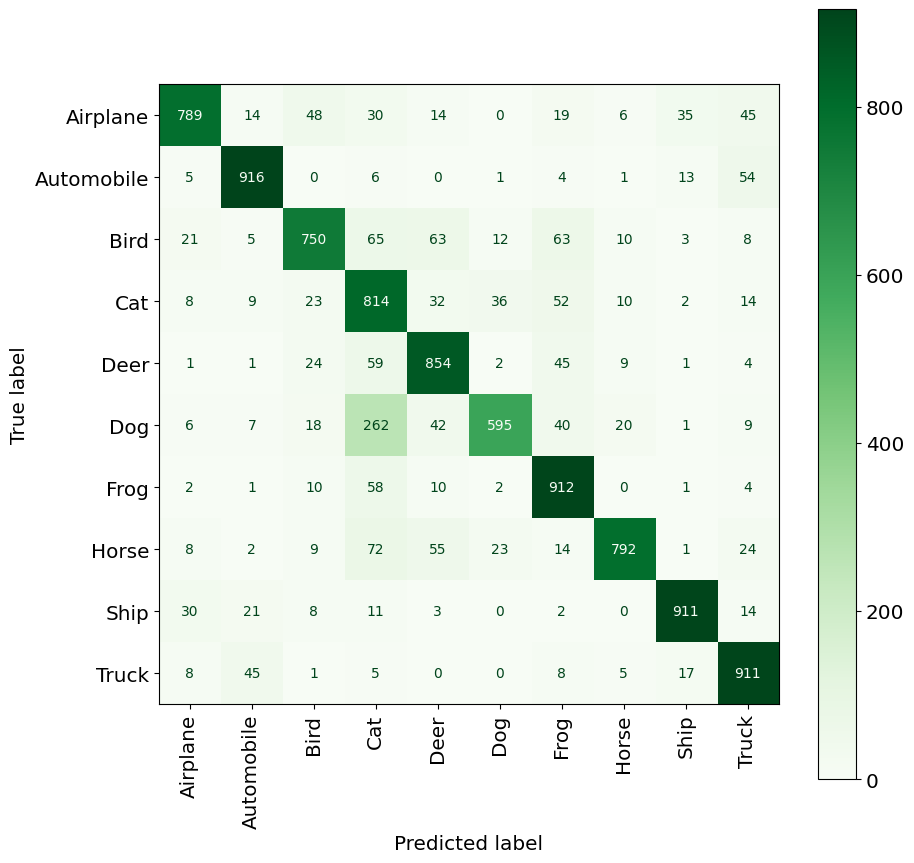

Accuracy of clean data in % = 82.44
313/313 [==============================] - 5s 16ms/step - loss: 1.1952 - accuracy: 0.6723 - precision: 0.7154 - recall: 0.6379
Test Accuracy of model : 67.23%
313/313 [==============================] - 3s 9ms/step


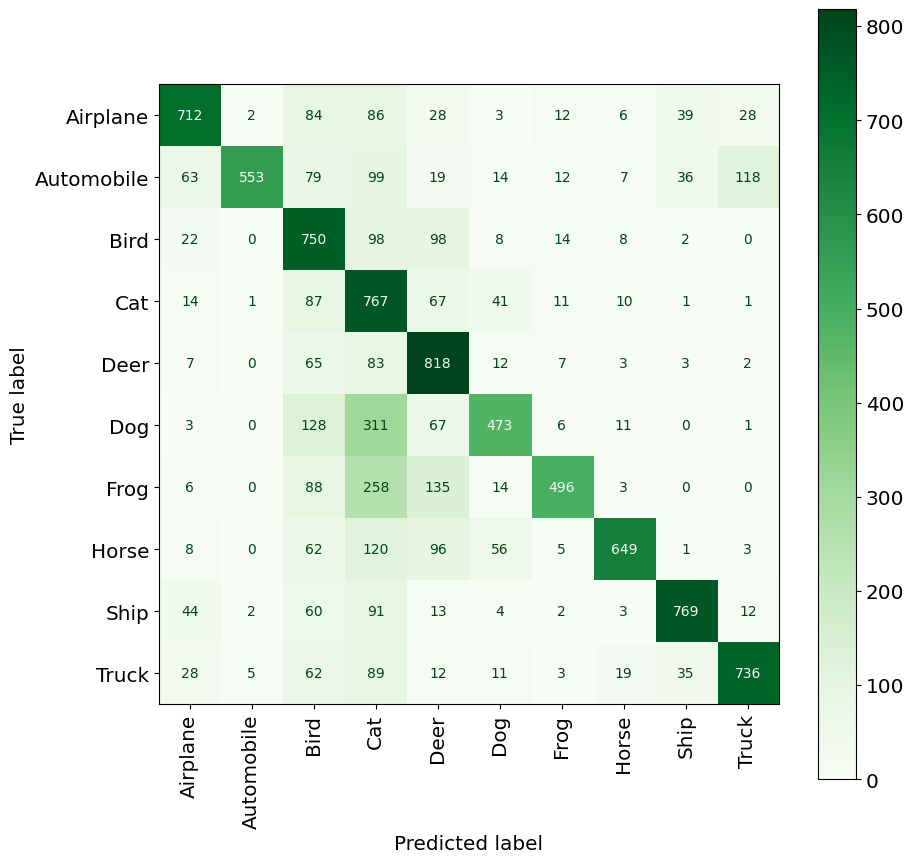

Accuracy of = 67.23
RLA = 18.449781659388638

ELA = 39.750121300339636
313/313 [==============================] - 5s 15ms/step - loss: 1.4868 - accuracy: 0.6048 - precision: 0.6442 - recall: 0.5685
Test Accuracy of model : 60.48%
313/313 [==============================] - 3s 9ms/step


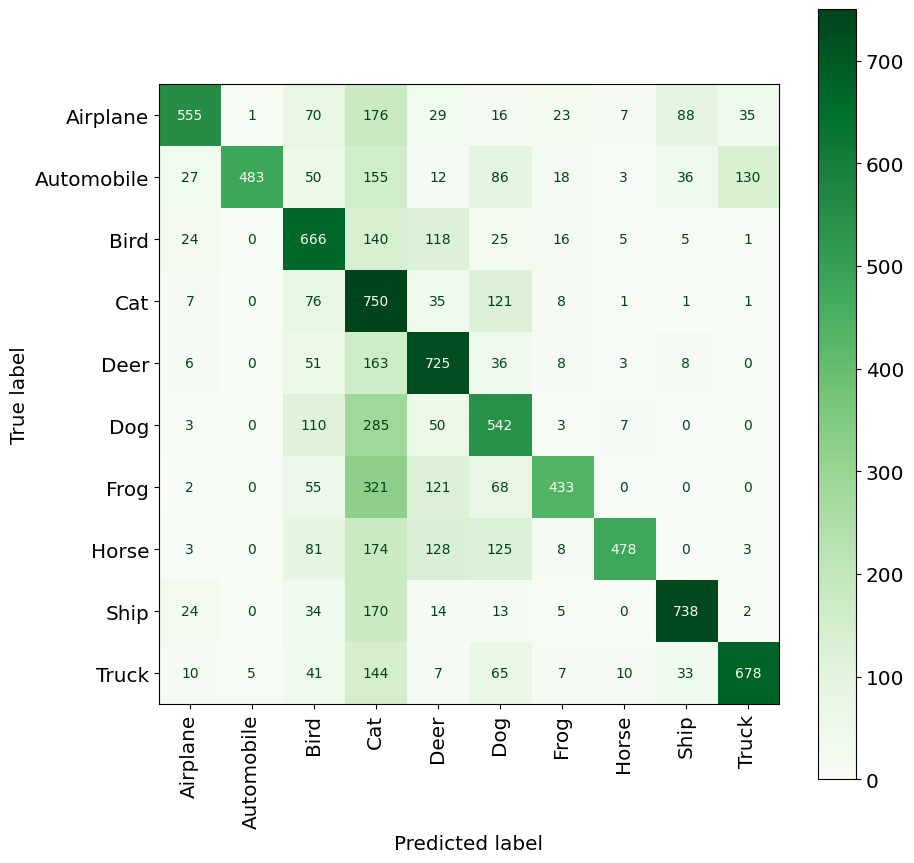

Accuracy of = 60.480000000000004
RLA = 26.637554585152834

ELA = 47.93789422610383
313/313 [==============================] - 4s 13ms/step - loss: 0.9815 - accuracy: 0.7367 - precision: 0.7637 - recall: 0.7162
Test Accuracy of model : 73.67%
313/313 [==============================] - 3s 10ms/step


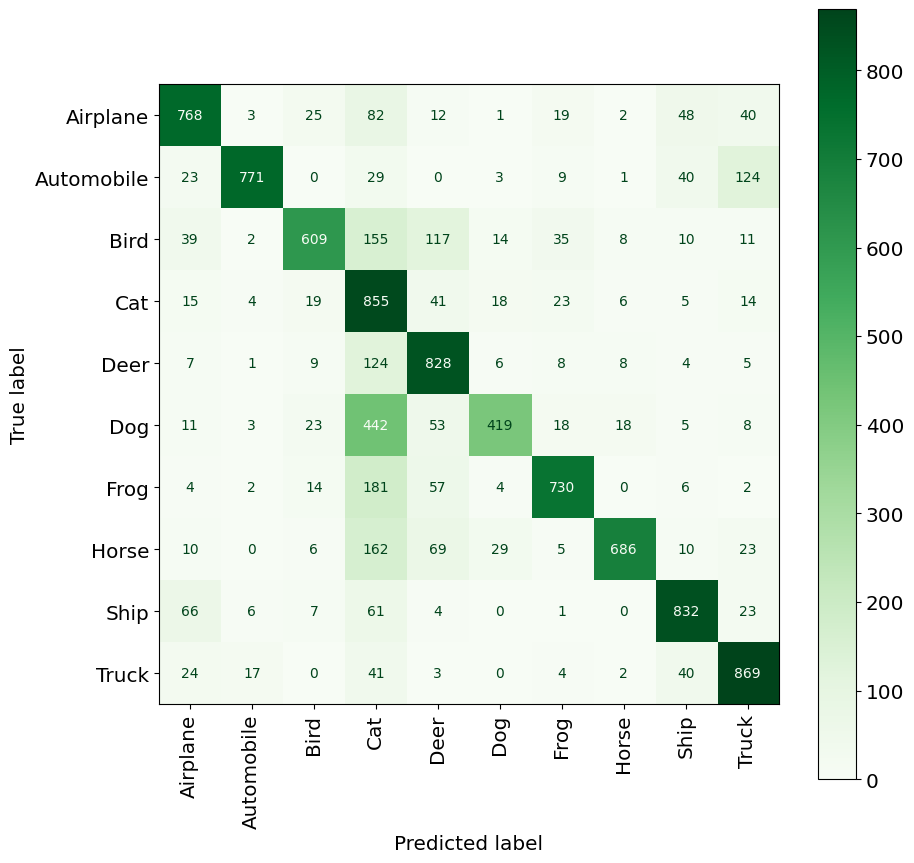

Accuracy of = 73.67
RLA = 10.638039786511397

ELA = 31.938379427462394
313/313 [==============================] - 5s 15ms/step - loss: 1.9594 - accuracy: 0.5485 - precision: 0.5752 - recall: 0.5214
Test Accuracy of model : 54.85%
313/313 [==============================] - 3s 9ms/step


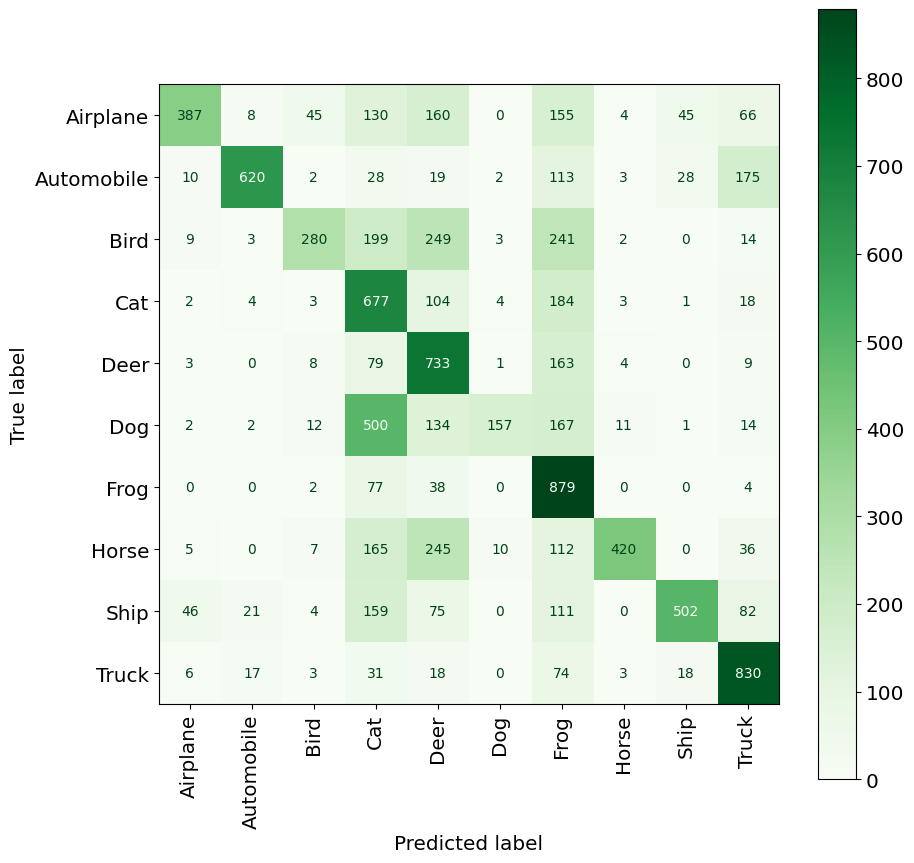

Accuracy of = 54.85
RLA = 33.46676370693837

ELA = 54.76710334788938
313/313 [==============================] - 4s 14ms/step - loss: 4.0434 - accuracy: 0.2693 - precision: 0.3044 - recall: 0.2385
Test Accuracy of model : 26.93%
313/313 [==============================] - 3s 11ms/step


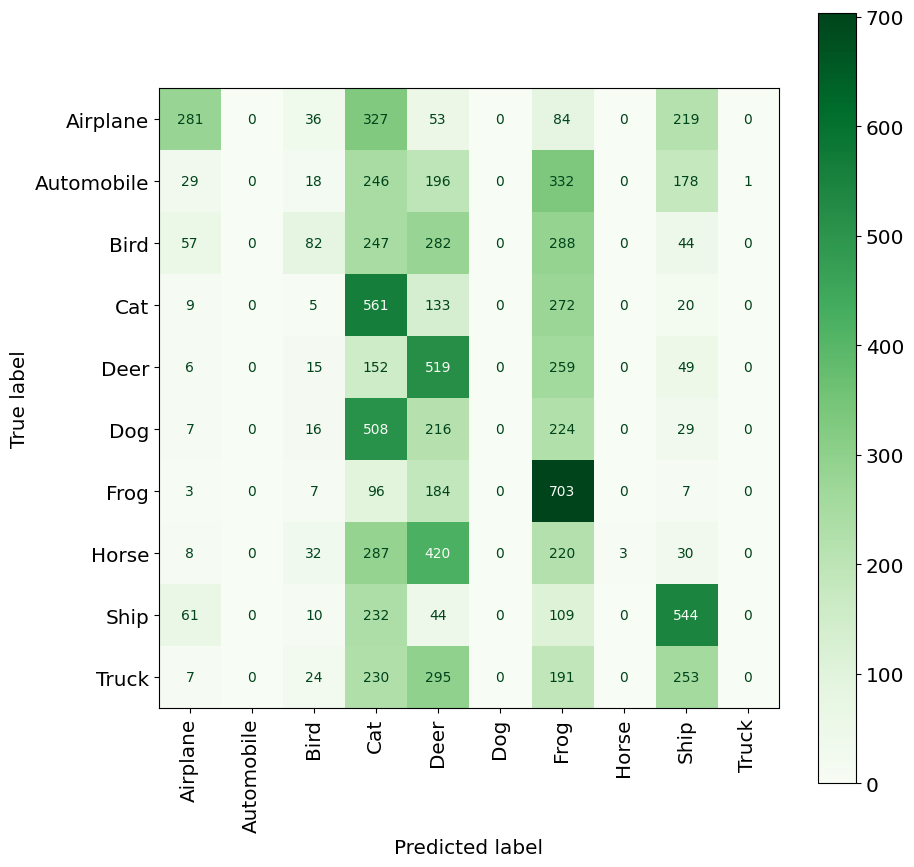

Accuracy of = 26.93
RLA = 67.33381853469189

ELA = 88.63415817564288


In [122]:
clean_acc = evaluate_clean_data(resnet50_model, X_test)
image_corruptions = (x_zoom_blur, x_gblur, x_bright, x_gnoise, x_contrast)
for i in image_corruptions:
  evaluate_corr_data(resnet50_model, i)
  i=+1

# **Evaluation of faulty RESNET50 on clean and corrupted test data**

313/313 [==============================] - 4s 12ms/step - loss: 1.1551 - accuracy: 0.6345 - precision: 0.7162 - recall: 0.5705
Test Accuracy of model : 63.45%
313/313 [==============================] - 3s 9ms/step


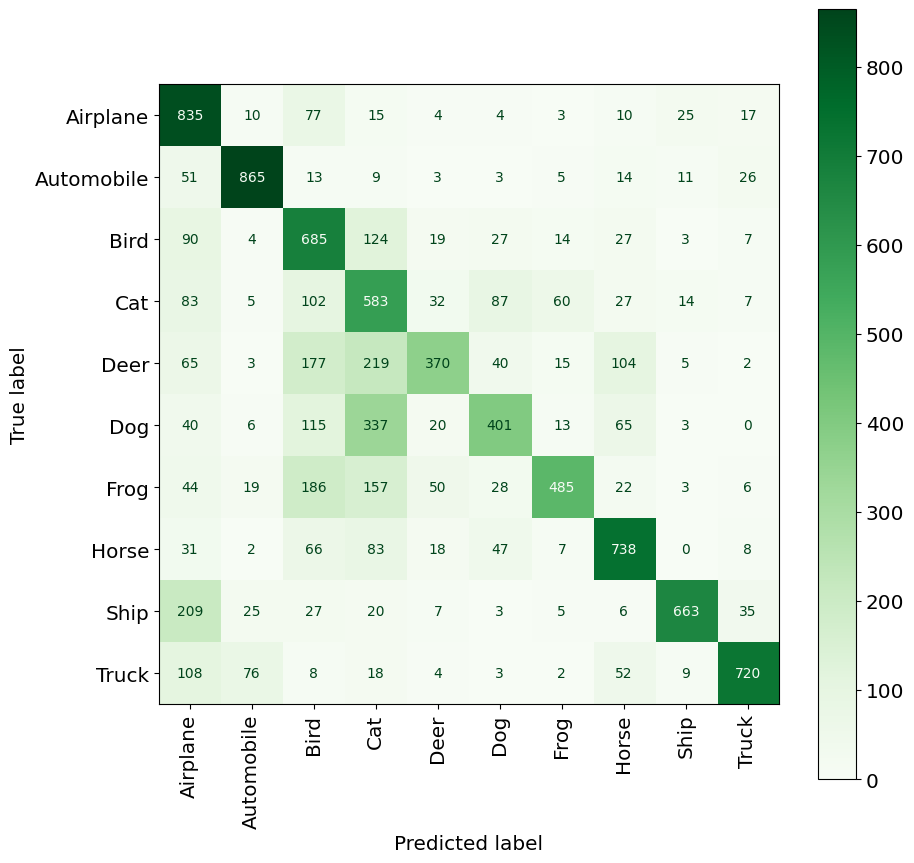

Accuracy of clean data in % = 63.449999999999996
313/313 [==============================] - 4s 14ms/step - loss: 2.2796 - accuracy: 0.3821 - precision: 0.4432 - recall: 0.3308
Test Accuracy of model : 38.21%
313/313 [==============================] - 3s 9ms/step


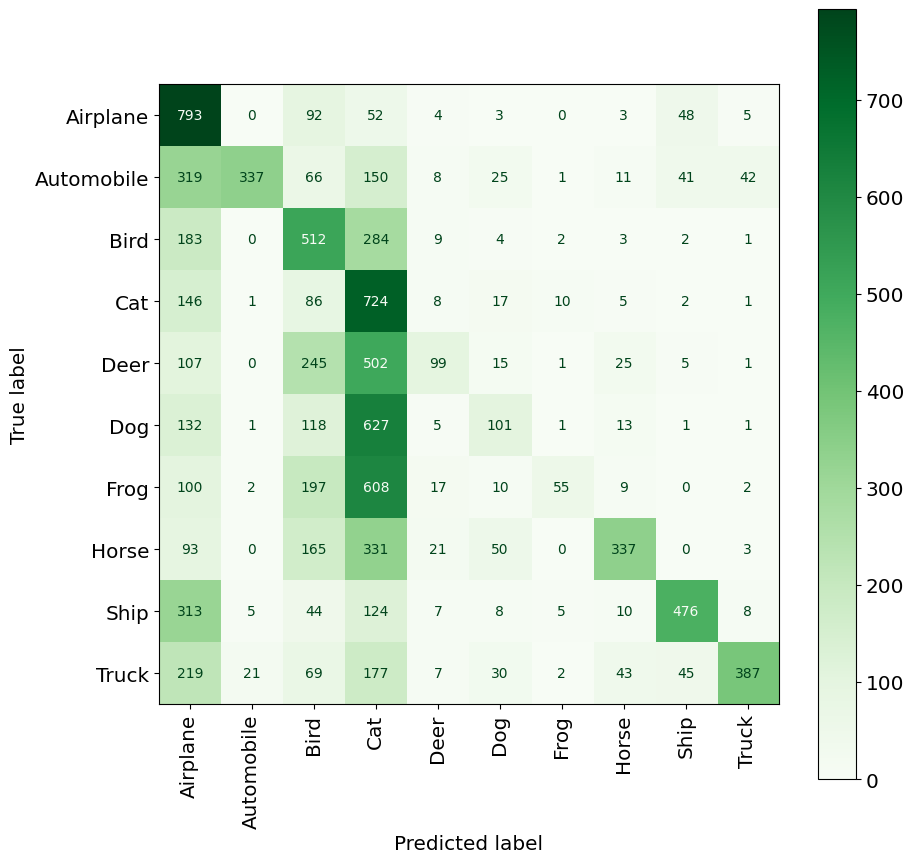

Accuracy of = 38.21
RLA = 39.77935382190701

ELA = 97.38376674546888
313/313 [==============================] - 4s 13ms/step - loss: 2.6594 - accuracy: 0.3220 - precision: 0.3644 - recall: 0.2754
Test Accuracy of model : 32.20%
313/313 [==============================] - 4s 12ms/step


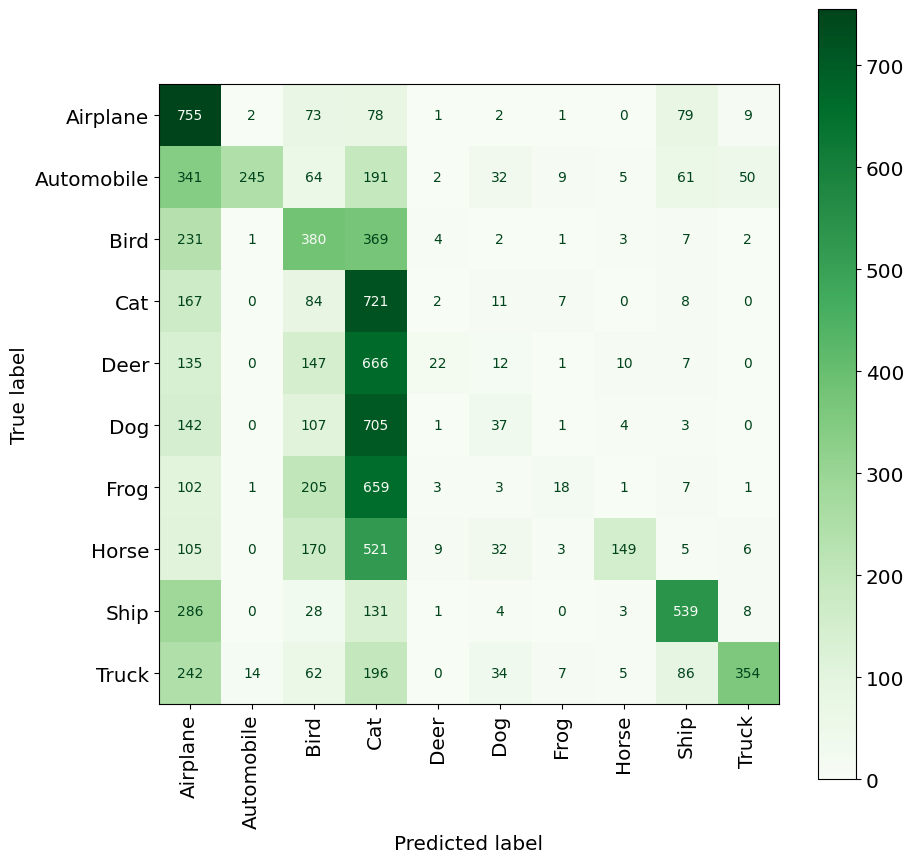

Accuracy of = 32.2
RLA = 49.251379038613074

ELA = 106.85579196217493
313/313 [==============================] - 4s 13ms/step - loss: 1.9017 - accuracy: 0.4684 - precision: 0.5491 - recall: 0.3984
Test Accuracy of model : 46.84%
313/313 [==============================] - 3s 9ms/step


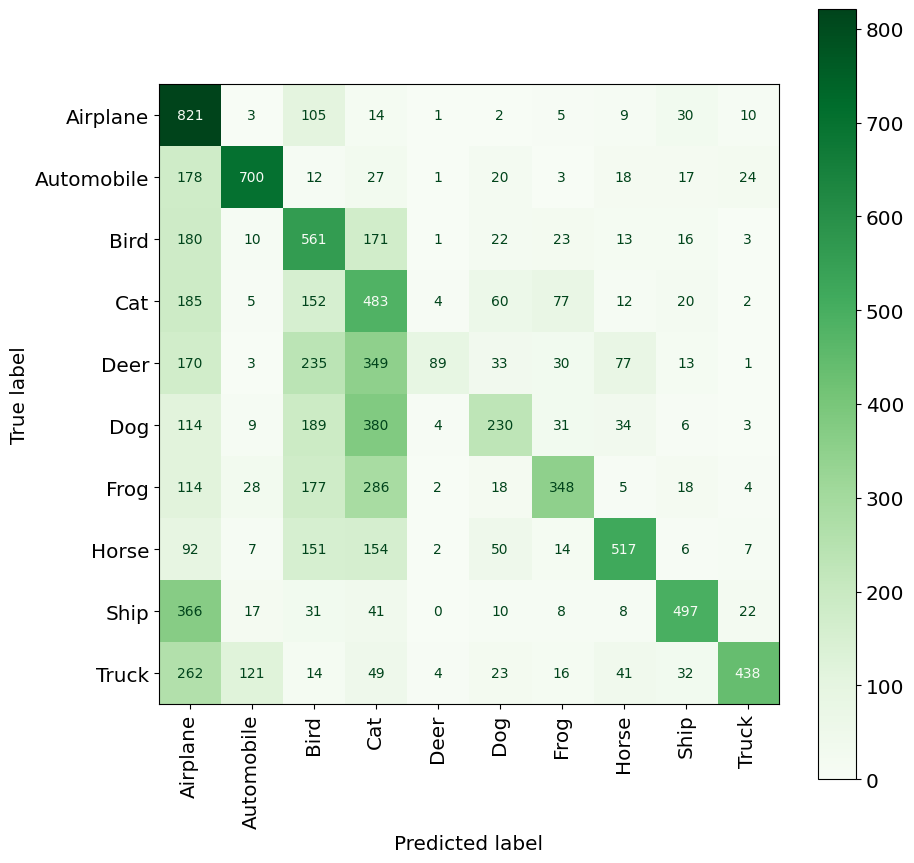

Accuracy of = 46.839999999999996
RLA = 26.178092986603623

ELA = 83.7825059101655
313/313 [==============================] - 4s 13ms/step - loss: 1.4899 - accuracy: 0.5368 - precision: 0.6340 - recall: 0.4597
Test Accuracy of model : 53.68%
313/313 [==============================] - 3s 9ms/step


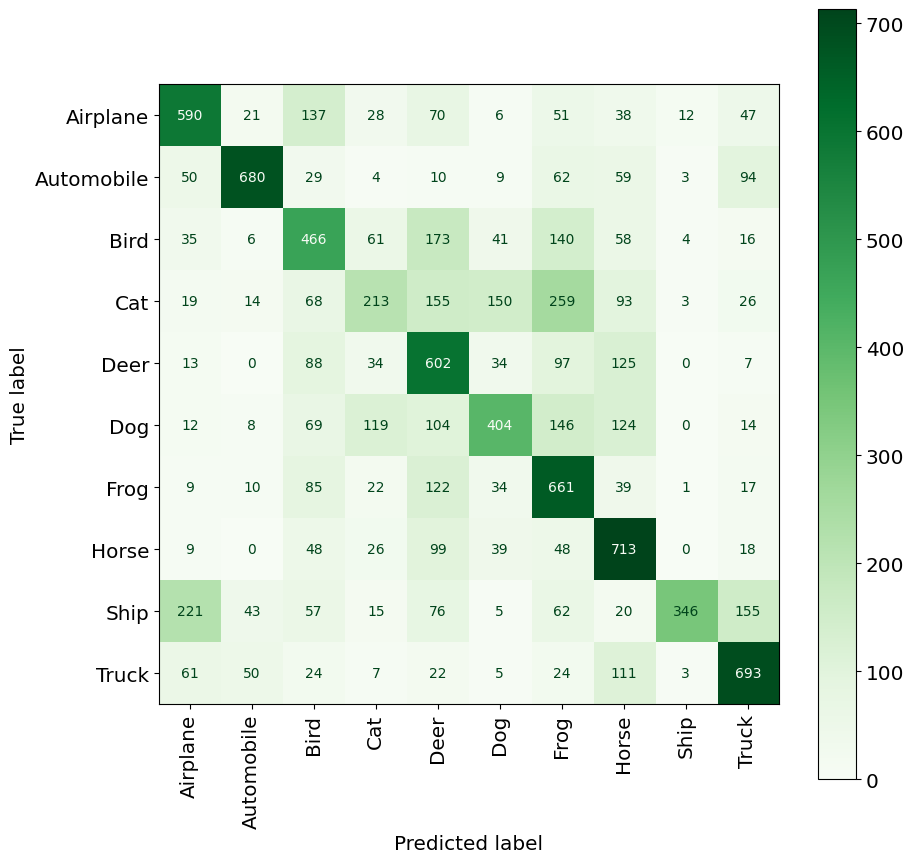

Accuracy of = 53.68000000000001
RLA = 15.397951142631976

ELA = 73.00236406619385
313/313 [==============================] - 5s 17ms/step - loss: 4.6777 - accuracy: 0.1410 - precision: 0.1482 - recall: 0.1243
Test Accuracy of model : 14.10%
313/313 [==============================] - 3s 9ms/step


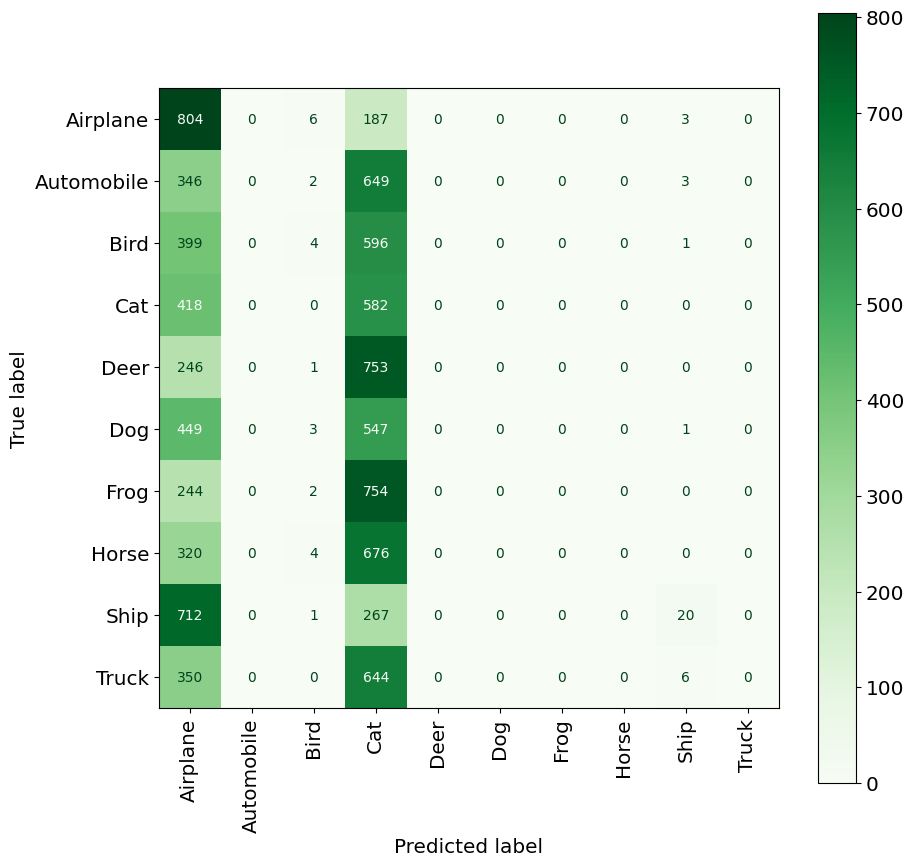

Accuracy of = 14.099999999999998
RLA = 77.77777777777779

ELA = 135.38219070133965


In [123]:
clean_acc = evaluate_clean_data(ResNet50_fault, X_test)
image_corruptions = (x_zoom_blur, x_gblur, x_bright, x_gnoise, x_contrast)
for i in image_corruptions:
  evaluate_corr_data(ResNet50_fault, i)
  i=+1

In [124]:
#print(classification_report(y_test, y_pred))

In [125]:
'''
from matplotlib import pylab
from pylab import *

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
'''

"\nfrom matplotlib import pylab\nfrom pylab import *\n\nparams = {'legend.fontsize': 'x-large',\n          'figure.figsize': (20, 7),\n         'axes.labelsize': 'x-large',\n         'axes.titlesize':'x-large',\n         'xtick.labelsize':'x-large',\n         'ytick.labelsize':'x-large'}\n\npylab.rcParams.update(params)\n"

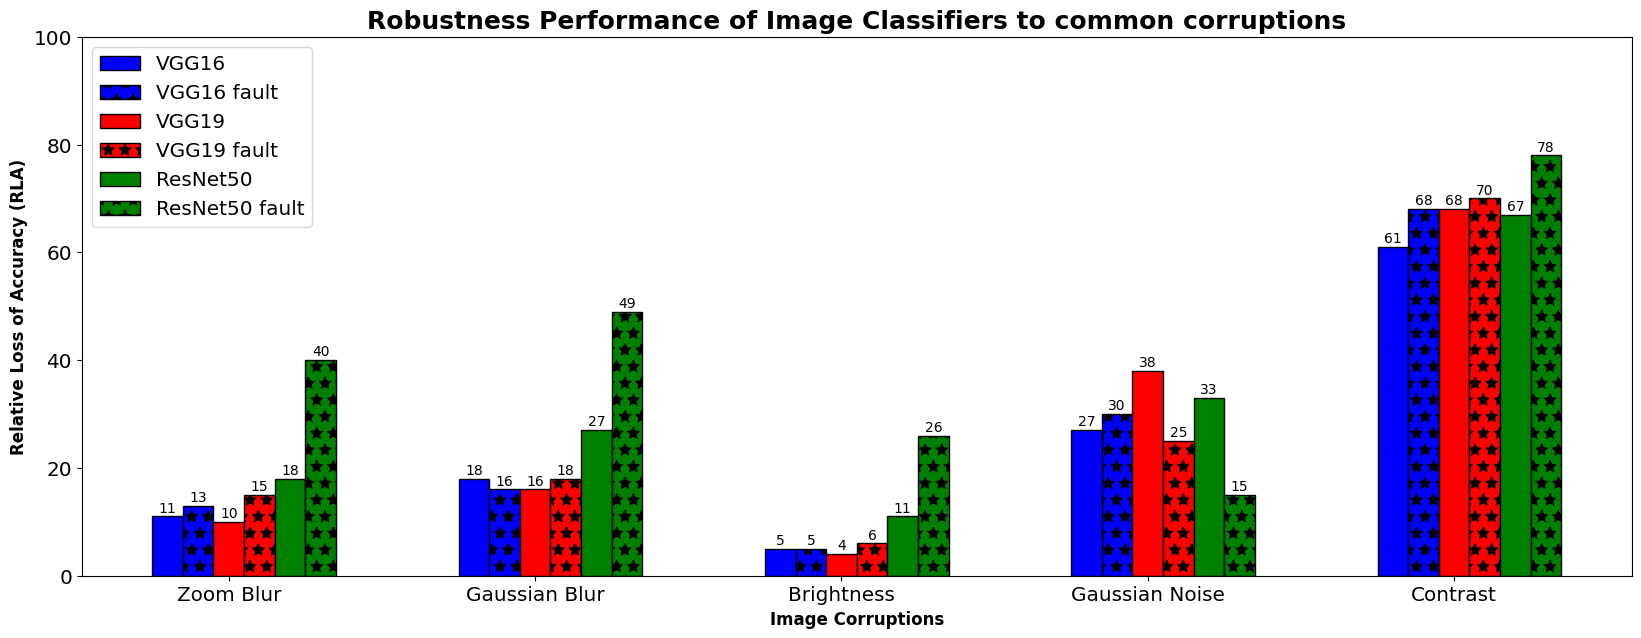

<Figure size 2000x700 with 0 Axes>

In [129]:
#RLA metric Visualizations

Image_Corruptions = ("Zoom Blur", "Gaussian Blur", "Brightness", "Gaussian Noise", "Contrast")
Clean_models = ("VGG16", "VGG19", "RESNET50")

#Dictionary containing lists of RLA and accuracy scores for all models
model_acc = {
      'VGG16': acc_vgg16,'VGG16_fault': acc_vgg16_fault,'VGG19': acc_vgg19, 'VGG19_fault': acc_vgg19_fault,'RESNET50': acc_resnet50,'RESNET50_fault': acc_ResNet50_fault
      }

model_RLA = {
      'VGG16': round(RLA_vgg16,4),'VGG16_fault': round(RLA_vgg16_fault,4),'VGG19': round(RLA_vgg19,4), 'VGG19_fault': round(RLA_vgg19_fault,4),'RESNET50': round(RLA_resnet50,4),'RESNET50_fault': round(RLA_ResNet50_fault,4)
      }

      
dummy_variable = 1                                # for selecting different plots
mark = 1                                          # for selecting all/one corruption

if dummy_variable == 0:                           # plot all models (clean and faulty) robustness performance vs accuracy to corruptions in a SCATTER PLOT
  i = 0                                           # select corruption type
  j = Image_Corruptions[i]                        # save corruption type in var j 

  #plot scatter plots
  d1 = plt.scatter(model_acc['VGG16'][i], model_RLA['VGG16'][i], s = 150, color='blue')
  d2 = plt.scatter(model_acc['VGG16_fault'][i], model_RLA['VGG16_fault'][i], s=150, marker="X", color='blue')

  d3 = plt.scatter(model_acc['VGG19'][i], model_RLA['VGG19'][i], s = 150, color='red')
  d4 = plt.scatter(model_acc['VGG19_fault'][i], model_RLA['VGG19_fault'][i], s = 150, marker="X",color='red') 

  d5 = plt.scatter(model_acc['RESNET50'][i], model_RLA['RESNET50'][i],s = 150, color='green') 
  d6 = plt.scatter(model_acc['RESNET50_fault'][i], model_RLA['RESNET50_fault'][i],s = 150, marker="X", color='green') 

  # get the x and y coordinates of the points in d1 and d2
  x1, y1 = d1.get_offsets().T
  x2, y2 = d2.get_offsets().T
  x3, y3 = d3.get_offsets().T
  x4, y4 = d4.get_offsets().T
  x5, y5 = d5.get_offsets().T
  x6, y6 = d6.get_offsets().T

  #connect the corresponding points with a line

  for i in range(len(x1)):
      plt.plot([x1[i], x2[i]], [y1[i], y2[i]], 'k--')
      plt.grid()
      #plt.text(x1[i]+0.1, y1[i], s='VGG16')
  for i in range(len(x3)):
      plt.plot([x3[i], x4[i]], [y3[i], y4[i]], 'k--')
  for i in range(len(x1)):
      plt.plot([x5[i], x6[i]], [y5[i], y6[i]], 'k--')

  #plot information
  plt.xlim(0,100)
  plt.ylim(0,100)
  plt.ylabel('Relative Loss of Accuracy (RLA)',fontweight="bold", fontsize="12")
  plt.xlabel('Accuracy [%]',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Classifier models to ' + j + ' Corruption' ,fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG16 fault", "VGG19", "VGG19 fault", "ResNet50", "ResNet50 fault"])
  plt.figure(figsize=(10,6))
  plt.show()

  
elif ((dummy_variable == 1) and (mark == 1)):      #plot model robustness performance for all corruptions in a GROUPED HISTOGRAM
  x = np.arange(len(Image_Corruptions))
  width = 0.1

  # plot data in grouped manner of bar type
  x1 = plt.bar(x-0.2, model_RLA['VGG16'], width, color='blue', edgecolor='black',linewidth=1)
  plt.bar_label(x1, padding =1, fontsize=10)
  x2 = plt.bar(x-0.1, model_RLA['VGG16_fault'], width, color='blue', hatch="*",edgecolor='black', linewidth=1)
  plt.bar_label(x2, padding =1, fontsize=10)
  x3 = plt.bar(x, model_RLA['VGG19'], width, color='red', edgecolor='black',linewidth=1)
  plt.bar_label(x3, padding =1, fontsize=10)
  x4 = plt.bar(x+0.1, model_RLA['VGG19_fault'], width, color='red', hatch="*", edgecolor='black',linewidth=1)
  plt.bar_label(x4, padding =1, fontsize=10)
  x5 = plt.bar(x+0.2, model_RLA['RESNET50'], width, color='green', edgecolor='black',linewidth=1)
  plt.bar_label(x5, padding =1, fontsize=10)
  x6 = plt.bar(x+0.3, model_RLA['RESNET50_fault'], width, color='green', hatch="*", edgecolor='black',linewidth=1)
  plt.bar_label(x6, padding =1, fontsize=10)
  plt.xticks(x, (Image_Corruptions))
  
  plt.ylabel('Relative Loss of Accuracy (RLA)',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xlabel('Image Corruptions',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Classifiers to common corruptions',fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG16 fault", "VGG19", "VGG19 fault","ResNet50", "ResNet50 fault"])
  plt.figure(figsize=(20,7))
  plt.show()

elif ((dummy_variable == 1) and (mark == 0)):     # plot model robustness of clean models for one selected corruption in a GROUPED HISTOGRAM PLOT
  i = 3                                           # select corruption type
  j = Image_Corruptions[i]                        # save corruption type in var j 
  width = 0.005

  # plot data in grouped manner of bar type
  X1 = plt.bar(0.2, model_RLA['VGG16'][i], width, color='blue')
  plt.bar_label(X1, padding =1)

  X2 = plt.bar(0.21, model_RLA['VGG19'][i], width, color='red')
  plt.bar_label(X2, padding =1)

  X3 = plt.bar(0.22, model_RLA['RESNET50'][i], width, color='green')
  plt.bar_label(X3, padding =1)
  
  #plot information
  plt.xticks([])
  plt.ylabel('Relative Loss of Accuracy (RLA)',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xlabel(j + ' Corruption',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of clean Image Classifiers to ' + j + ' Corruption',fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG19","ResNet50"])
  plt.figure(figsize=(10,6))
  plt.show()

elif mark ==2:
  x = np.arange(len(Image_Corruptions))
  width = 0.2

  # plot data in grouped manner of bar type
  X1 = plt.bar(x-0.2, model_RLA['VGG16'], width, color='blue')
  plt.bar_label(X1, padding =1)

  X2 = plt.bar(x, model_RLA['VGG19'], width, color='red')
  plt.bar_label(X2, padding =1)

  X3 = plt.bar(x+0.2, model_RLA['RESNET50'], width, color='green')
  plt.bar_label(X3, padding =1)

  plt.ylabel('Relative Loss of Accuracy (RLA)',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xticks(x, (Image_Corruptions))
  plt.xlabel('Image Corruptions',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Classifiers to common corruptions',fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG19","ResNet50"])
  plt.figure(figsize=(20,7))
  plt.show()

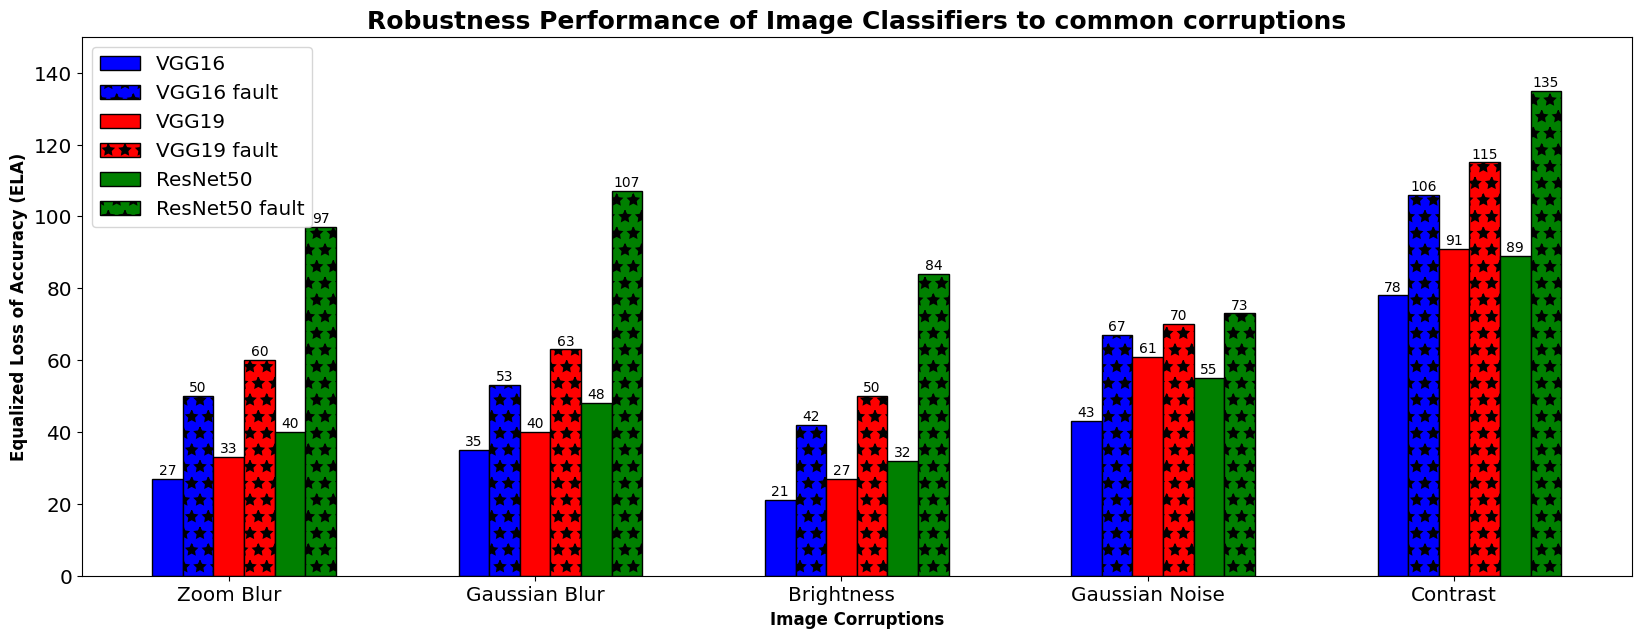

<Figure size 2000x700 with 0 Axes>

In [130]:
#ELA metric Visualizations

Image_Corruptions = ("Zoom Blur", "Gaussian Blur", "Brightness", "Gaussian Noise", "Contrast")
Clean_models = ("VGG16", "VGG19", "RESNET50")

model_ELA = {
      'VGG16': round(ELA_vgg16,2),'VGG16_fault': round(ELA_vgg16_fault,2),'VGG19': round(ELA_vgg19,2), 'VGG19_fault': round(ELA_vgg19_fault,2),'RESNET50': round(ELA_resnet50,2),'RESNET50_fault': round(ELA_ResNet50_fault,2)
      }
      
dummy = 1                                # for selecting different plots
mark_v = 1                                          # for selecting all/one corruption

if dummy == 0:                           # plot all models (clean and faulty) robustness performance vs accuracy to corruptions in a SCATTER PLOT
  i = 0                                           # select corruption type
  j = Image_Corruptions[i]                        # save corruption type in var j 

  #plot scatter plots
  d1 = plt.scatter(model_acc['VGG16'][i], model_ELA['VGG16'][i], s = 150, color='blue')
  d2 = plt.scatter(model_acc['VGG16_fault'][i], model_ELA['VGG16_fault'][i], s=150, marker="X", color='blue')

  d3 = plt.scatter(model_acc['VGG19'][i], model_ELA['VGG19'][i], s = 150, color='red')
  d4 = plt.scatter(model_acc['VGG19_fault'][i], model_ELA['VGG19_fault'][i], s = 150, marker="X",color='red') 

  d5 = plt.scatter(model_acc['RESNET50'][i], model_ELA['RESNET50'][i],s = 150, color='green') 
  d6 = plt.scatter(model_acc['RESNET50_fault'][i], model_ELA['RESNET50_fault'][i],s = 150, marker="X", color='green') 

  # get the x and y coordinates of the points in d1 and d2
  x1, y1 = d1.get_offsets().T
  x2, y2 = d2.get_offsets().T
  x3, y3 = d3.get_offsets().T
  x4, y4 = d4.get_offsets().T
  x5, y5 = d5.get_offsets().T
  x6, y6 = d6.get_offsets().T

  #connect the corresponding points with a line

  for i in range(len(x1)):
      plt.plot([x1[i], x2[i]], [y1[i], y2[i]], 'k--')
      plt.grid()
  for i in range(len(x3)):
      plt.plot([x3[i], x4[i]], [y3[i], y4[i]], 'k--')
  for i in range(len(x1)):
      plt.plot([x5[i], x6[i]], [y5[i], y6[i]], 'k--')

  #plot information
  plt.xlim(0,100)
  plt.ylim(0,150)
  plt.ylabel('Equalized Loss of Accuracy (ELA)',fontweight="bold", fontsize="12")
  plt.xlabel('Accuracy [%]',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Classifier models to ' + j + ' Corruption' ,fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG16 fault", "VGG19", "VGG19 fault", "ResNet50", "ResNet50 fault"])
  plt.figure(figsize=(10,6))
  plt.show()

  
elif ((dummy == 1) and (mark_v == 1)):      #plot model robustness performance for all corruptions in a GROUPED HISTOGRAM
  x = np.arange(len(Image_Corruptions))
  width = 0.1

  # plot data in grouped manner of bar type
  x1 = plt.bar(x-0.2, model_ELA['VGG16'], width, color='blue', edgecolor='black',linewidth=1)
  plt.bar_label(x1, padding =1, fontsize=10)
  x2 = plt.bar(x-0.1, model_ELA['VGG16_fault'], width, color='blue', hatch="*",edgecolor='black', linewidth=1)
  plt.bar_label(x2, padding =1, fontsize=10)
  x3 = plt.bar(x, model_ELA['VGG19'], width, color='red', edgecolor='black',linewidth=1)
  plt.bar_label(x3, padding =1, fontsize=10)
  x4 = plt.bar(x+0.1, model_ELA['VGG19_fault'], width, color='red', hatch="*", edgecolor='black',linewidth=1)
  plt.bar_label(x4, padding =1, fontsize=10)
  x5 = plt.bar(x+0.2, model_ELA['RESNET50'], width, color='green', edgecolor='black',linewidth=1)
  plt.bar_label(x5, padding =1, fontsize=10)
  x6 = plt.bar(x+0.3, model_ELA['RESNET50_fault'], width, color='green', hatch="*", edgecolor='black',linewidth=1)
  plt.bar_label(x6, padding =1, fontsize=10)
  plt.xticks(x, (Image_Corruptions))
  
  plt.ylabel('Equalized Loss of Accuracy (ELA)',fontweight="bold", fontsize="12")
  plt.ylim(0, 150)
  plt.xlabel('Image Corruptions',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Classifiers to common corruptions',fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG16 fault", "VGG19", "VGG19 fault","ResNet50", "ResNet50 fault"])
  plt.figure(figsize=(20,7))
  plt.show()

elif ((dummy == 1) and (mark_v == 0)):     # plot model robustness of clean models for one selected corruption in a GROUPED HISTOGRAM PLOT
  i = 3                                           # select corruption type
  j = Image_Corruptions[i]                        # save corruption type in var j 
  width = 0.005

  # plot data in grouped manner of bar type
  X1 = plt.bar(0.2, model_ELA['VGG16'][i], width, color='blue')
  plt.bar_label(X1, padding =1)

  X2 = plt.bar(0.21, model_ELA['VGG19'][i], width, color='red')
  plt.bar_label(X2, padding =1)

  X3 = plt.bar(0.22, model_ELA['RESNET50'][i], width, color='green')
  plt.bar_label(X3, padding =1)
  
  #plot information
  plt.xticks([])
  plt.ylabel('Equalized Loss of Accuracy (ELA)',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xlabel(j + ' Corruption',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of clean Image Classifiers to ' + j + ' Corruption',fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG19","ResNet50"])
  plt.figure(figsize=(10,6))
  plt.show()

elif mark_v ==2:
  x = np.arange(len(Image_Corruptions))
  width = 0.2

  # plot data in grouped manner of bar type
  X1 = plt.bar(x-0.2, model_ELA['VGG16'], width, color='blue')
  plt.bar_label(X1, padding =1)

  X2 = plt.bar(x, model_ELA['VGG19'], width, color='red')
  plt.bar_label(X2, padding =1)

  X3 = plt.bar(x+0.2, model_ELA['RESNET50'], width, color='green')
  plt.bar_label(X3, padding =1)

  plt.ylabel('Equalized Loss of Accuracy (ELA)',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xticks(x, (Image_Corruptions))
  plt.xlabel('Image Corruptions',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Classifiers to common corruptions',fontweight="bold", fontsize="18")
  plt.legend(loc='upper left')
  plt.legend(["VGG16", "VGG19","ResNet50"])
  plt.figure(figsize=(20,7))
  plt.show()